# Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import RocCurveDisplay

In [13]:
!pip install xgboost

# Inspecting the data

In [14]:
from google.colab import drive

drive.mount('/content/drive')

ruta_archivo = '/content/drive/MyDrive/Nuclio/sample_mmp.csv'

df = pd.read_csv(ruta_archivo, low_memory=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df.head()

Unnamed: 0                 MachineIdentifier   ProductName EngineVersion  \
0     8427007  f1cd864e97bae82bdf96523e1a539121  win8defender   1.1.15100.1   
1     8829090  fd5ba6f5b75325ec0423a6c67cc75942  win8defender   1.1.15100.1   
2     2731904  4e628391e7cc7c482fb3286f486dbd25  win8defender   1.1.15100.1   
3     1359513  270a2e9d028144a4df12a9e3da79fba5  win8defender   1.1.15200.1   
4      236059  06ca8fa8d32c2abdc5b3577d676b3269  win8defender   1.1.15200.1   

        AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
0  4.18.1807.18075  1.273.1234.0       0               7.0                 0   
1  4.18.1807.18075  1.273.1282.0       0               7.0                 0   
2   4.9.10586.1106   1.273.781.0       0               7.0                 0   
3  4.18.1807.18075  1.275.1639.0       0               7.0                 0   
4  4.18.1807.18075   1.275.511.0       0               7.0                 0   

   DefaultBrowsersIdentifier  ...  Census_FirmwareVersionIdentifier  \
0                        NaN  ...                           19951.0   
1                        NaN  ...                           48753.0   
2                        NaN  ...                           33111.0   
3                        NaN  ...                           48473.0   
4                        NaN  ...                            4343.0   

   Census_IsSecureBootEnabled  Census_IsWIMBootEnabled  \
0                           0                      NaN   
1                           0                      0.0   
2                           1                      0.0   
3                           1                      NaN   
4                           1                      NaN   

   Census_IsVirtualDevice  Census_IsTouchEnabled  Census_IsPenCapable  \
0                     0.0                      0                    0   
1                     0.0                      0                    0   
2                     0.0                      1                    1   
3                     0.0                      0                    0   
4                     0.0                      1                    0   

   Census_IsAlwaysOnAlwaysConnectedCapable  Wdft_IsGamer  \
0                                      0.0           0.0   
1                                      0.0           1.0   
2                                      0.0           0.0   
3                                      0.0           0.0   
4                                      0.0           1.0   

   Wdft_RegionIdentifier HasDetections  
0                   11.0             1  
1                    3.0             0  
2                   15.0             0  
3                   15.0             1  
4                   13.0             1  

[5 rows x 84 columns]

In [16]:
df.info() # i see variables w nulls + with wrong/unefficient dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 84 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Unnamed: 0                                         500000 non-null  int64  
 1   MachineIdentifier                                  500000 non-null  object 
 2   ProductName                                        500000 non-null  object 
 3   EngineVersion                                      500000 non-null  object 
 4   AppVersion                                         500000 non-null  object 
 5   AvSigVersion                                       500000 non-null  object 
 6   IsBeta                                             500000 non-null  int64  
 7   RtpStateBitfield                                   498168 non-null  float64
 8   IsSxsPassiveMode                                   500000 non-null  int64 

To use less memory, I'm going to change the dtypes:
* object - category
* binary - int8
* binary w nans - float16
* 64 bits - 32 or 16 bits

In [17]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [18]:
df = df.astype(dtypes)

In [19]:
df.shape

(500000, 84)

In [20]:
# checking if the target variable is balanced (it is)
df.HasDetections.value_counts(normalize=True)

0    0.500094
1    0.499906
Name: HasDetections, dtype: float64

## Variables with little explanatory power

### Variables with many nulls

I saw in `.describe()` that some columns have many nulls, so i'm going to create a ranking that sorts in descending order the number of nulls.

In [21]:
nans = []
perc = []
for cols in df:
    nans.append(df[cols].isnull().sum())
    perc.append(df[cols].isnull().sum()/df.shape[0]*100)

In [22]:
missing_data = pd.DataFrame({"Variables":df.columns,"Nans": nans, "%": perc}).sort_values("Nans", ascending=False)
missing_data[missing_data["Nans"]!=0].reset_index(drop=True)

Variables    Nans        %
0                                             PuaMode  499874  99.9748
1                               Census_ProcessorClass  497918  99.5836
2                           DefaultBrowsersIdentifier  475939  95.1878
3                          Census_IsFlightingInternal  415225  83.0450
4                          Census_InternalBatteryType  355603  71.1206
5                               Census_ThresholdOptIn  318104  63.6208
6                             Census_IsWIMBootEnabled  317666  63.5332
7                                         SmartScreen  178596  35.7192
8                              OrganizationIdentifier  154563  30.9126
9                                               SMode   29848   5.9696
10                                     CityIdentifier   18240   3.6480
11                                       Wdft_IsGamer   16950   3.3900
12                              Wdft_RegionIdentifier   16950   3.3900
13              Census_InternalBatteryNumberOfCharges   15038   3.0076
14              Census_FirmwareManufacturerIdentifier   10349   2.0698
15                   Census_FirmwareVersionIdentifier    9061   1.8122
16                           Census_IsFlightsDisabled    8933   1.7866
17                          Census_OEMModelIdentifier    5764   1.1528
18                           Census_OEMNameIdentifier    5381   1.0762
19                                           Firewall    5162   1.0324
20                            Census_TotalPhysicalRAM    4556   0.9112
21            Census_IsAlwaysOnAlwaysConnectedCapable    4040   0.8080
22                 Census_OSInstallLanguageIdentifier    3332   0.6664
23                                    IeVerIdentifier    3209   0.6418
24                    Census_PrimaryDiskTotalCapacity    2976   0.5952
25                   Census_SystemVolumeTotalCapacity    2976   0.5952
26  Census_InternalPrimaryDiagonalDisplaySizeInInches    2654   0.5308
27  Census_InternalPrimaryDisplayResolutionHorizontal    2650   0.5300
28    Census_InternalPrimaryDisplayResolutionVertical    2650   0.5300
29                    Census_ProcessorModelIdentifier    2349   0.4698
30                          Census_ProcessorCoreCount    2347   0.4694
31             Census_ProcessorManufacturerIdentifier    2347   0.4694
32                                  AVProductsEnabled    1938   0.3876
33                          AVProductStatesIdentifier    1938   0.3876
34                                AVProductsInstalled    1938   0.3876
35                                        IsProtected    1926   0.3852
36                                   RtpStateBitfield    1832   0.3664
37                             Census_IsVirtualDevice     901   0.1802
38                         Census_PrimaryDiskTypeName     709   0.1418
39                                       UacLuaenable     623   0.1246
40                             Census_ChassisTypeName      37   0.0074
41                                  GeoNameIdentifier      16   0.0032
42                       Census_PowerPlatformRoleName       2   0.0004
43                                         OsBuildLab       1   0.0002

The first 7 variables have more than 60% of nulls, so I don't think they're going to give me any info.

### Similar variables

There are two variables that are equal, so I'm keeping only one.

In [ ]:
df.Census_OSEdition.unique()

['Professional', 'Core', 'CoreCountrySpecific', 'CoreSingleLanguage', 'Education', ..., 'EducationN', 'ProfessionalEducationN', 'ProfessionalWorkstation', 'CloudN', 'ProfessionalWorkstationN']
Length: 22
Categories (22, object): ['Cloud', 'CloudN', 'Core', 'CoreCountrySpecific', ...,
                          'ServerDatacenterEval', 'ServerSolution', 'ServerStandard', 'ServerStandardEval']

In [ ]:
df.Census_OSSkuName.unique()

['PROFESSIONAL', 'CORE', 'CORE_COUNTRYSPECIFIC', 'CORE_SINGLELANGUAGE', 'EDUCATION', ..., 'EDUCATION_N', 'PRO_WORKSTATION', 'CLOUDN', 'PRO_WORKSTATION_N', 'UNLICENSED']
Length: 21
Categories (21, object): ['CLOUD', 'CLOUDN', 'CORE', 'CORE_COUNTRYSPECIFIC', ...,
                          'SB_SOLUTION_SERVER', 'STANDARD_EVALUATION_SERVER', 'STANDARD_SERVER',
                          'UNLICENSED']

Deleting variables with many nulls/ similar variables

In [3]:
cols_eliminar =['DefaultBrowsersIdentifier',
                'PuaMode',
                'Census_IsFlightingInternal',
                'Census_ThresholdOptIn',
                'Census_IsWIMBootEnabled',
                'Census_InternalBatteryType',
                'Unnamed: 0',
                'Census_ProcessorClass',
                'Census_OSSkuName']

df.drop(cols_eliminar,inplace=True,axis=1)

# EDA

Splitting variables in numerical, categorical, ids and target.

In [23]:
target_col = 'HasDetections'
id_cols = ['MachineIdentifier',
           'AVProductStatesIdentifier',
           'CityIdentifier',
           'OrganizationIdentifier',
           'GeoNameIdentifier',
           'LocaleEnglishNameIdentifier',
           'IeVerIdentifier',
           'Census_OEMNameIdentifier',
           'Census_OEMModelIdentifier',
           'Census_ProcessorManufacturerIdentifier',
           'Census_ProcessorModelIdentifier',
           'Census_InternalBatteryNumberOfCharges',
           'Census_OSInstallLanguageIdentifier',
           'Census_OSUILocaleIdentifier',
           'Census_FirmwareManufacturerIdentifier',
           'Census_FirmwareVersionIdentifier',
           'Wdft_RegionIdentifier']

In [24]:
# Numerical variables excluding target_col y id_cols
numeric_cols = df.select_dtypes(include=['int8', 'int16', 'int32', 'float16', 'float32']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col and c not in id_cols]
print("Numerical variables: ", numeric_cols)

Numerical variables:  ['IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 'DefaultBrowsersIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'OsBuild', 'OsSuite', 'IsProtected', 'AutoSampleOptIn', 'SMode', 'Firewall', 'UacLuaenable', 'Census_ProcessorCoreCount', 'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_IsPortableOperatingSystem', 'Census_IsFlightingInternal', 'Census_IsFlightsDisabled', 'Census_ThresholdOptIn', 'Census_IsSecureBootEnabled', 'Census_IsWIMBootEnabled', 'Census_IsVirtualDevice', 'Census_IsTouchEnabled', 'Census_IsPenCapable', 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer']


In [25]:
# Categorical variables excluding id_cols
categoric_cols = df.select_dtypes(include=['category']).columns.tolist()
categoric_cols = [c for c in categoric_cols if c not in id_cols]  # Aquí no excluyo target porque no es categórica
print("Categorical variables: ", categoric_cols)

Categorical variables:  ['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'Platform', 'Processor', 'OsVer', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'PuaMode', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_DeviceFamily', 'Census_ProcessorClass', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_InternalBatteryType', 'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing']


## Part I: Univariant

### 1. Numeric

In [26]:
df.describe()

Unnamed: 0         IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
count  5.000000e+05  500000.000000          498168.0     500000.000000   
mean   4.458888e+06       0.000002               NaN          0.017242   
std    2.575619e+06       0.001414               0.0          0.130172   
min    2.000000e+00       0.000000               0.0          0.000000   
25%    2.227692e+06       0.000000               7.0          0.000000   
50%    4.461368e+06       0.000000               7.0          0.000000   
75%    6.690936e+06       0.000000               7.0          0.000000   
max    8.921471e+06       1.000000              35.0          1.000000   

       DefaultBrowsersIdentifier  AVProductStatesIdentifier  \
count                    24061.0              498062.000000   
mean                         inf               47850.906250   
std                          inf               14023.085938   
min                          1.0                   3.000000   
25%                        788.0               49480.000000   
50%                       1632.0               53447.000000   
75%                       2380.0               53447.000000   
max                       3208.0               70492.000000   

       AVProductsInstalled  AVProductsEnabled         HasTpm  \
count             498062.0           498062.0  500000.000000   
mean                   NaN                NaN       0.987816   
std                    0.0                0.0       0.109707   
min                    1.0                0.0       0.000000   
25%                    1.0                1.0       1.000000   
50%                    1.0                1.0       1.000000   
75%                    2.0                1.0       1.000000   
max                    5.0                4.0       1.000000   

       CountryIdentifier  ...  Census_FirmwareVersionIdentifier  \
count      500000.000000  ...                     490939.000000   
mean          108.037454  ...                      33030.996094   
std            63.068540  ...                      21220.162109   
min             1.000000  ...                         10.000000   
25%            51.000000  ...                      13156.000000   
50%            97.000000  ...                      33070.000000   
75%           162.000000  ...                      52436.000000   
max           222.000000  ...                      72091.000000   

       Census_IsSecureBootEnabled  Census_IsWIMBootEnabled  \
count               500000.000000                 182334.0   
mean                     0.485438                      0.0   
std                      0.499788                      0.0   
min                      0.000000                      0.0   
25%                      0.000000                      0.0   
50%                      0.000000                      0.0   
75%                      1.000000                      0.0   
max                      1.000000                      0.0   

       Census_IsVirtualDevice  Census_IsTouchEnabled  Census_IsPenCapable  \
count                499099.0          500000.000000        500000.000000   
mean                      0.0               0.125434             0.037744   
std                       0.0               0.331211             0.190577   
min                       0.0               0.000000             0.000000   
25%                       0.0               0.000000             0.000000   
50%                       0.0               0.000000             0.000000   
75%                       0.0               0.000000             0.000000   
max                       1.0               1.000000             1.000000   

       Census_IsAlwaysOnAlwaysConnectedCapable  Wdft_IsGamer  \
count                                 495960.0      483050.0   
mean                                       0.0           NaN   
std                                        0.0           0.0   
min                                        0.0           0.0   
25%                 

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

In [28]:
def plot_histogram_and_boxplot(df, column_name):
    """Plots the histogram and boxplot of a numerical variable.

    Parameters:
    column_name (str): Numeric variable's name

    Returns:
    None
    """
    # Remove nulls in variable
    df_ = df.loc[df[column_name].notnull()]

    fig = plt.figure()
    fig.suptitle(column_name, fontsize=16)
    fig.subplots_adjust(wspace = 0.3)

    ax1 = fig.add_subplot(121)
    ax1.set_title("histogram")
    ax1.hist(df_[column_name], bins = 25)

    ax2 = fig.add_subplot(122)
    ax2.set_title("boxplot")
    ax2.boxplot(df_[column_name], vert = False)

<ipython-input-28-92706dca1290>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


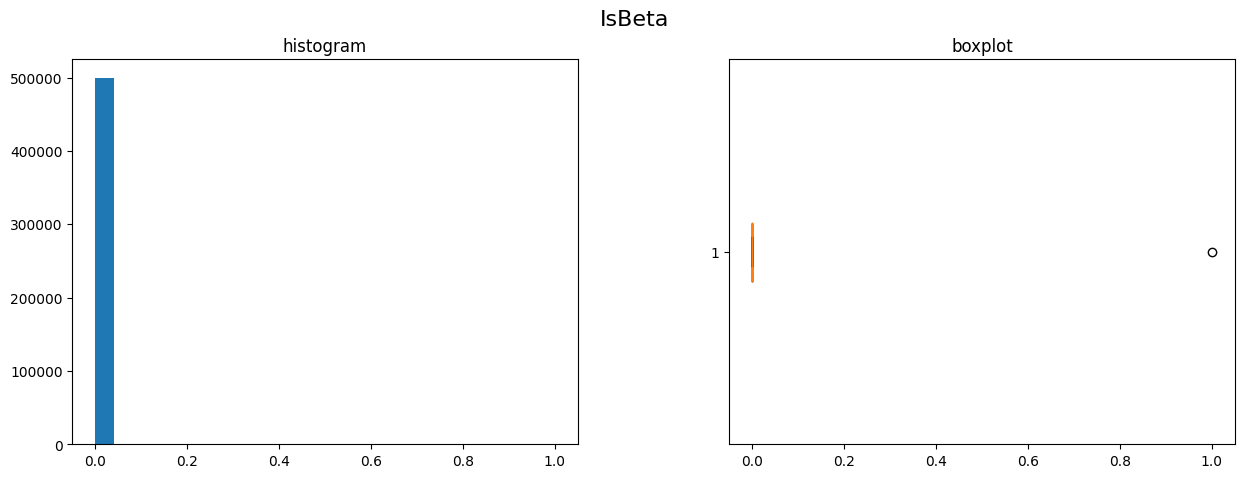

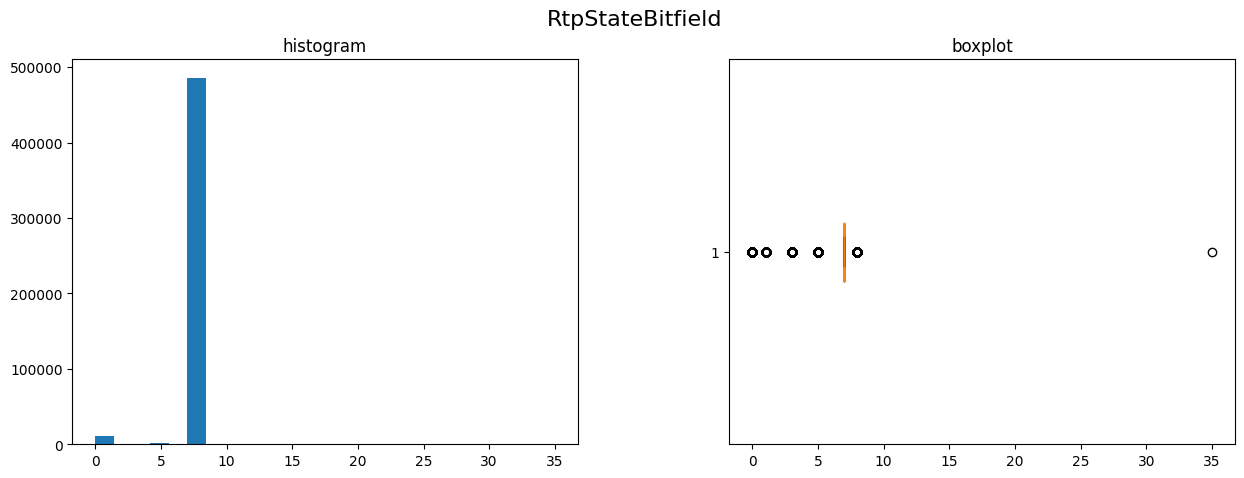

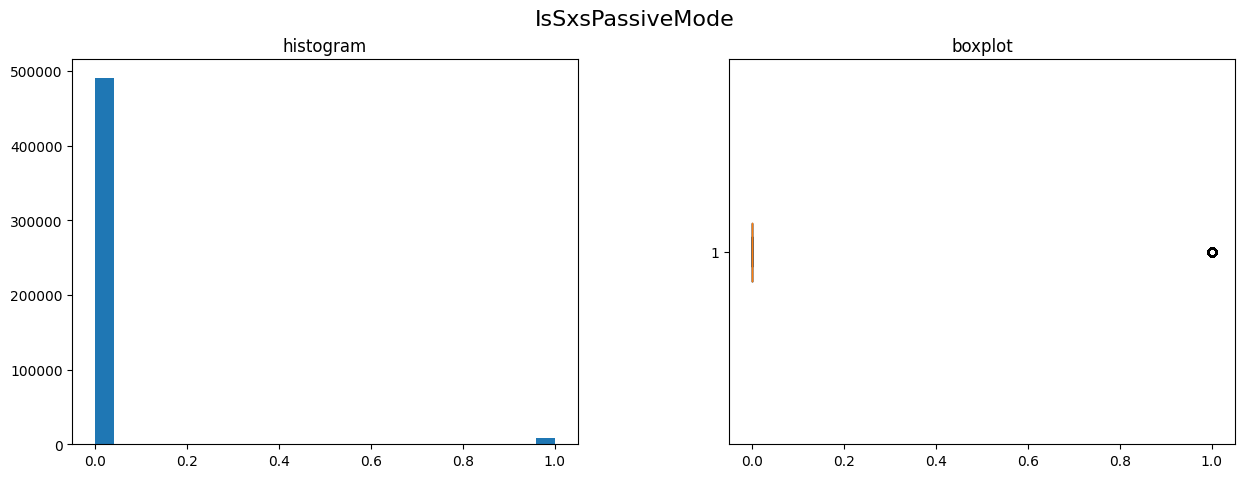

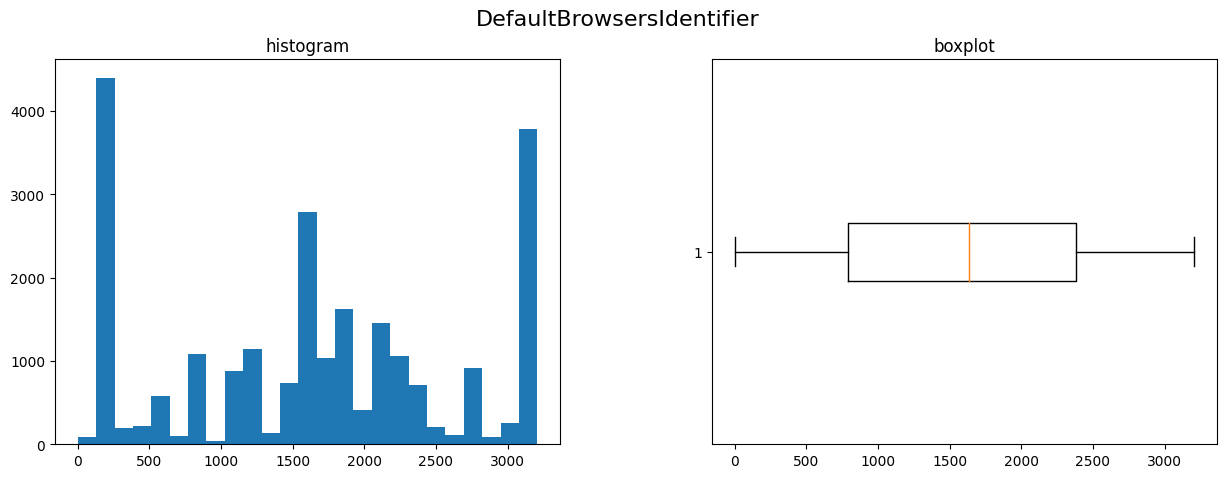

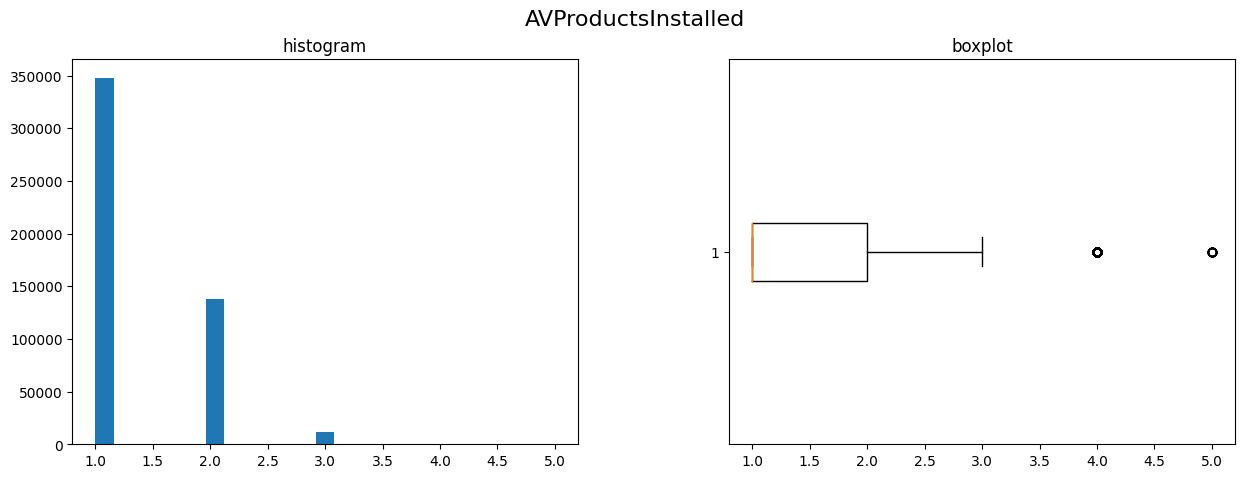

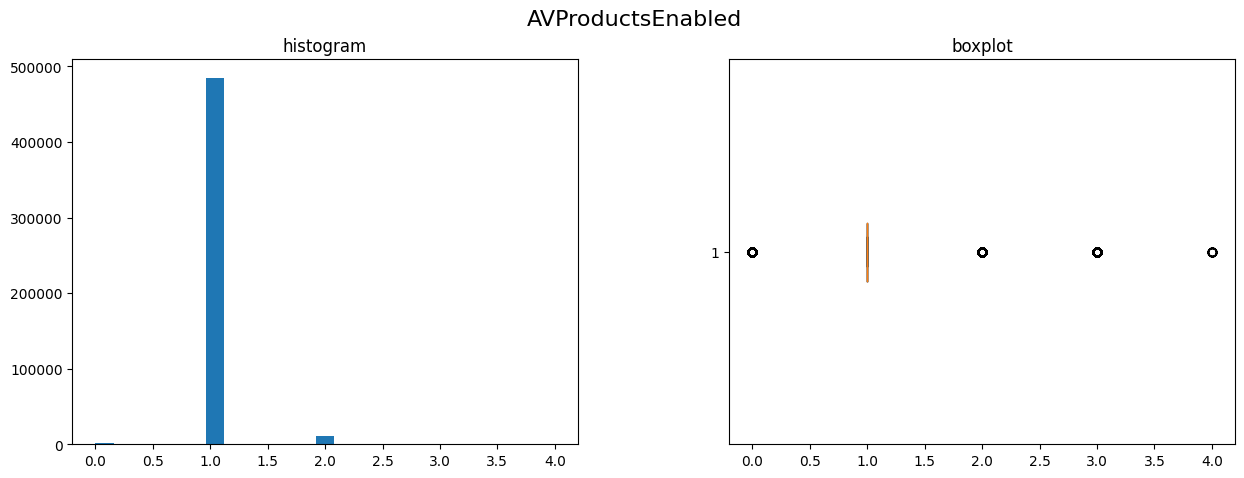

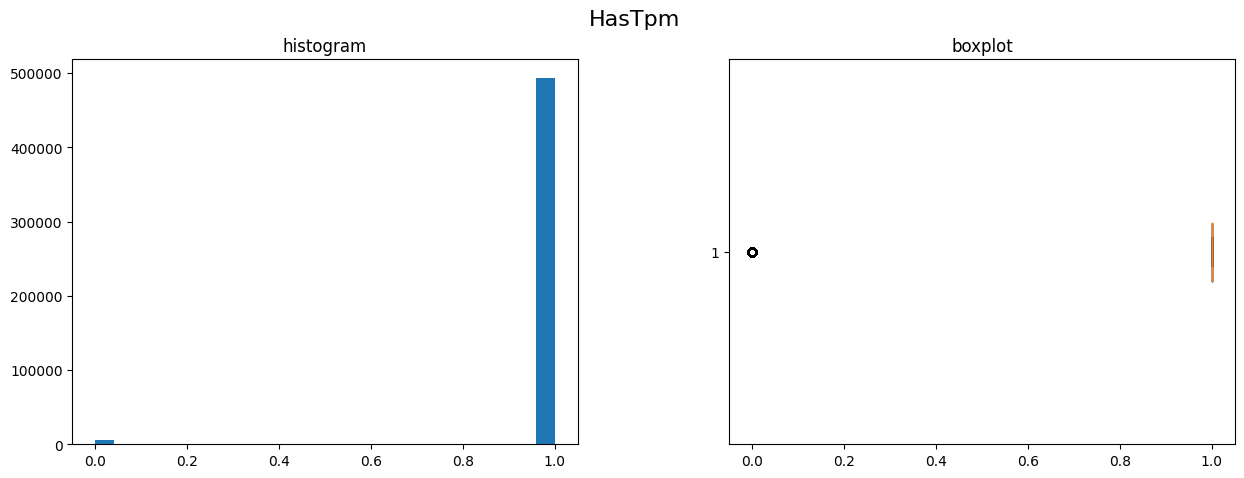

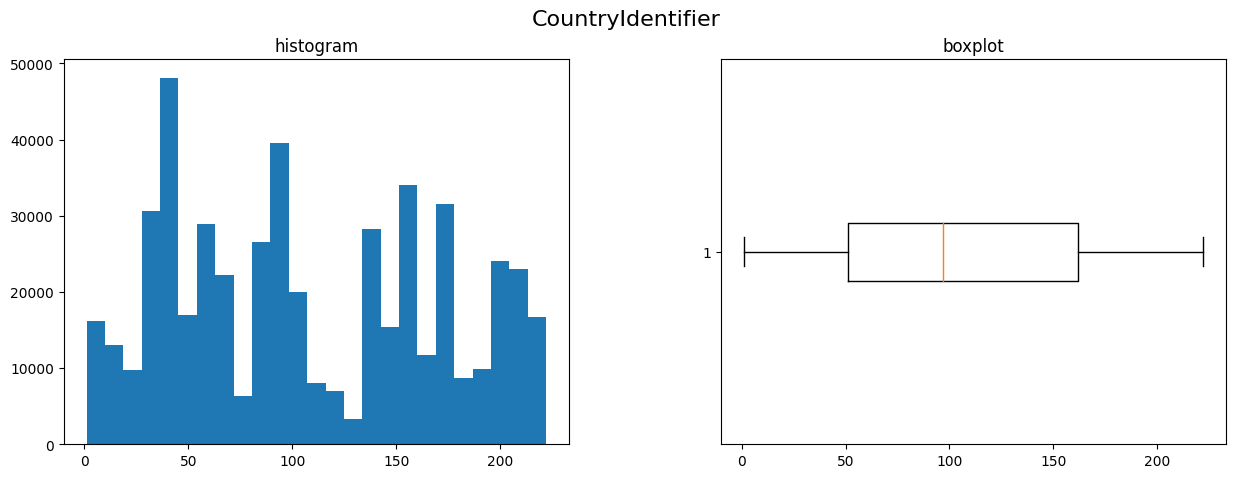

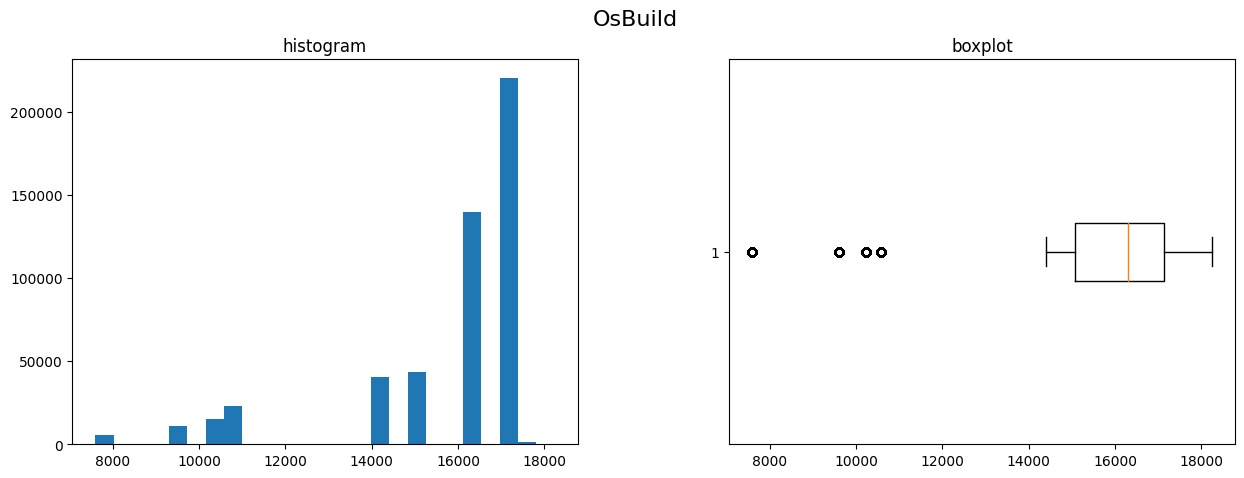

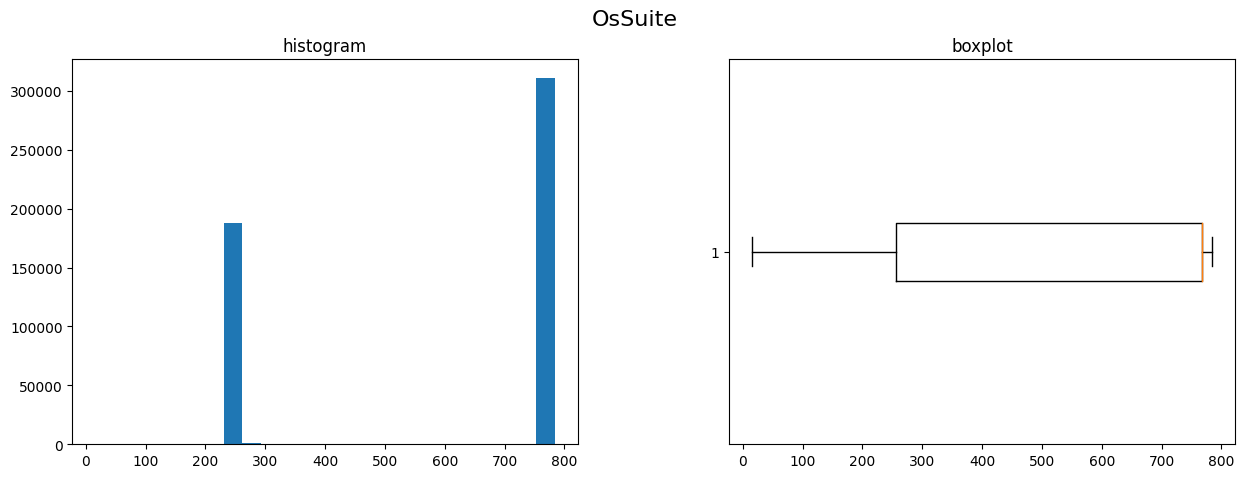

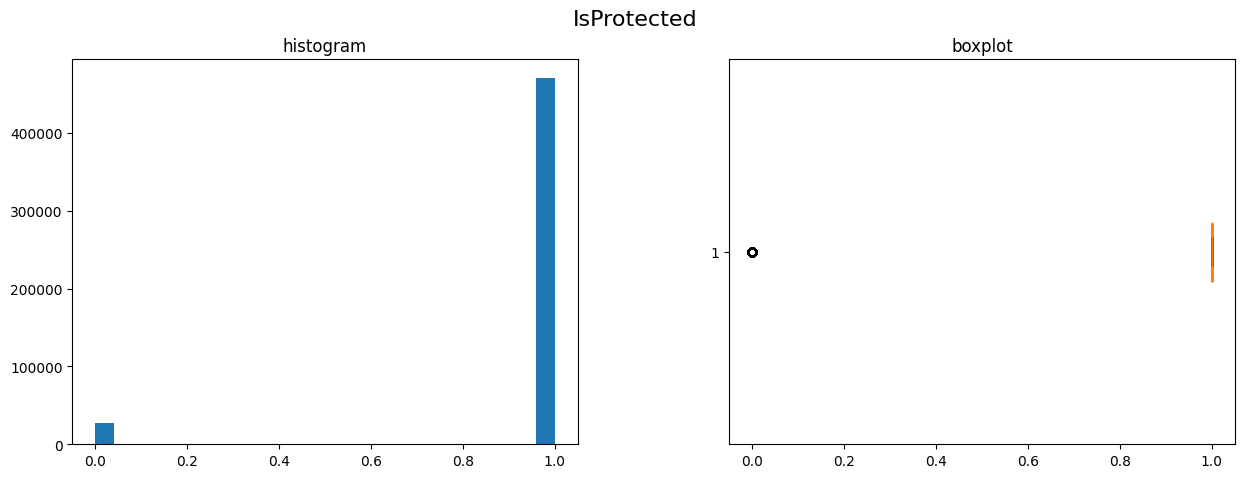

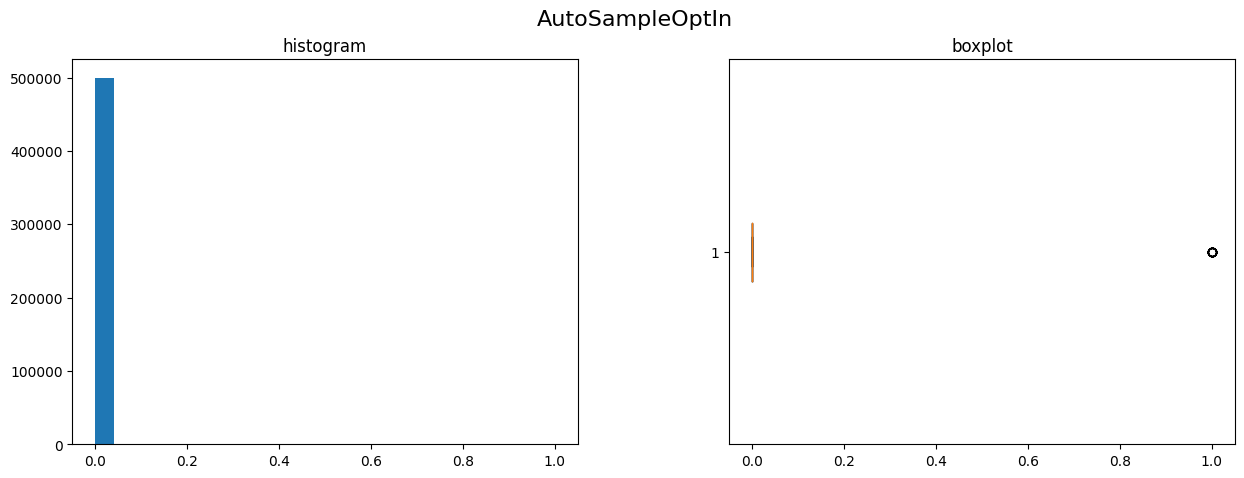

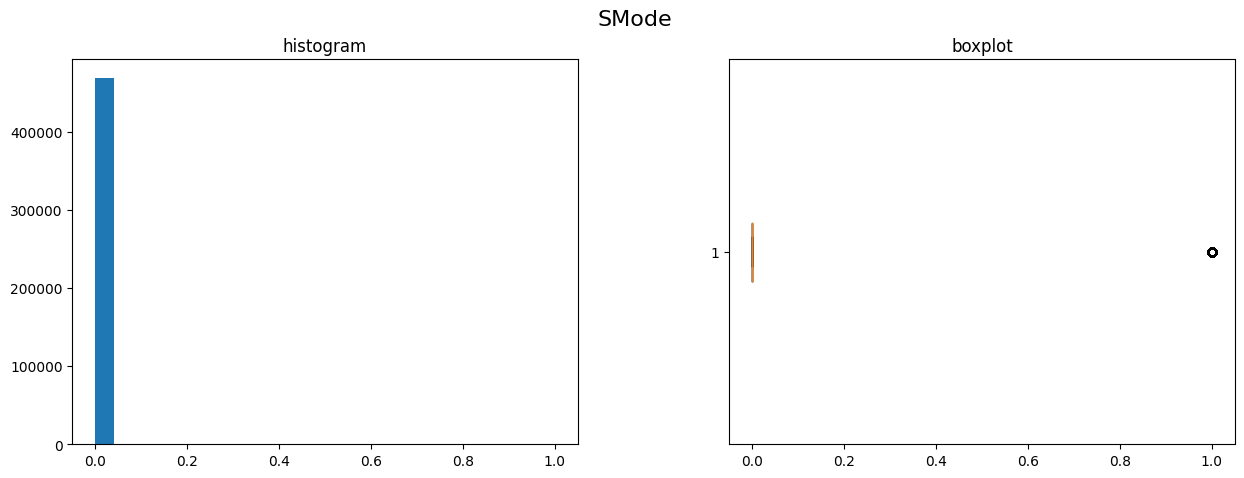

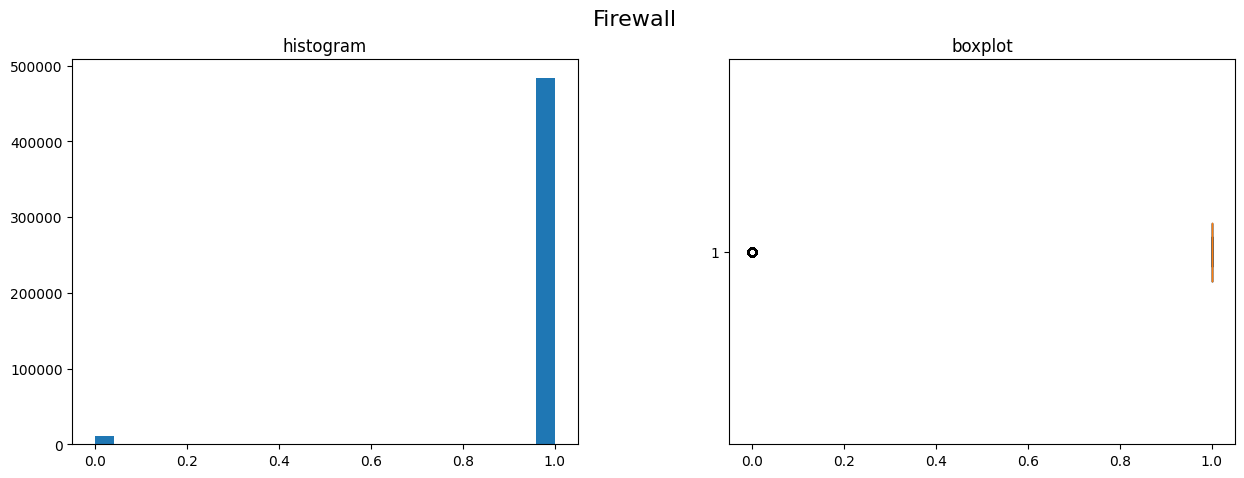

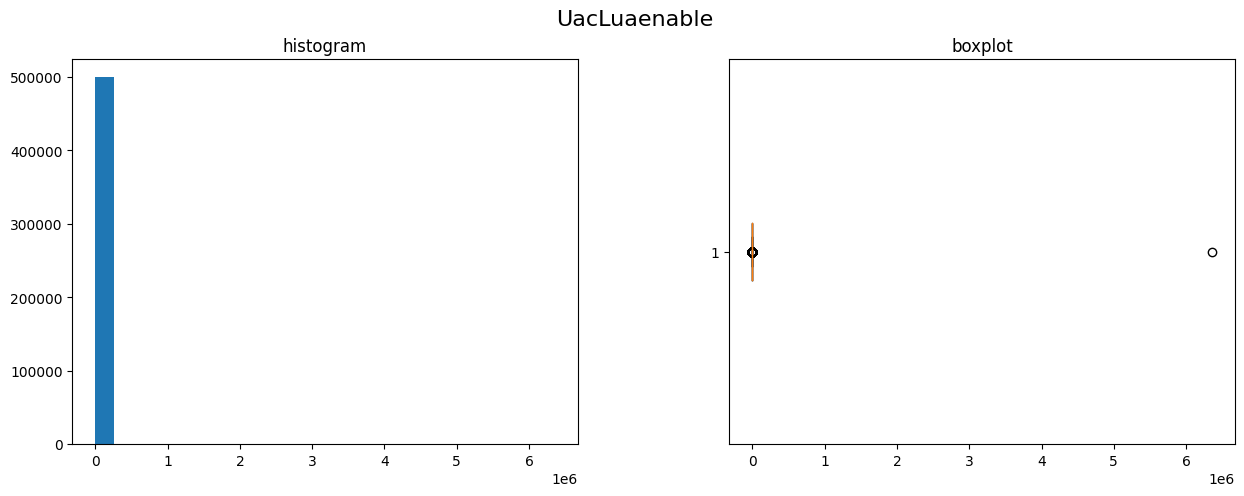

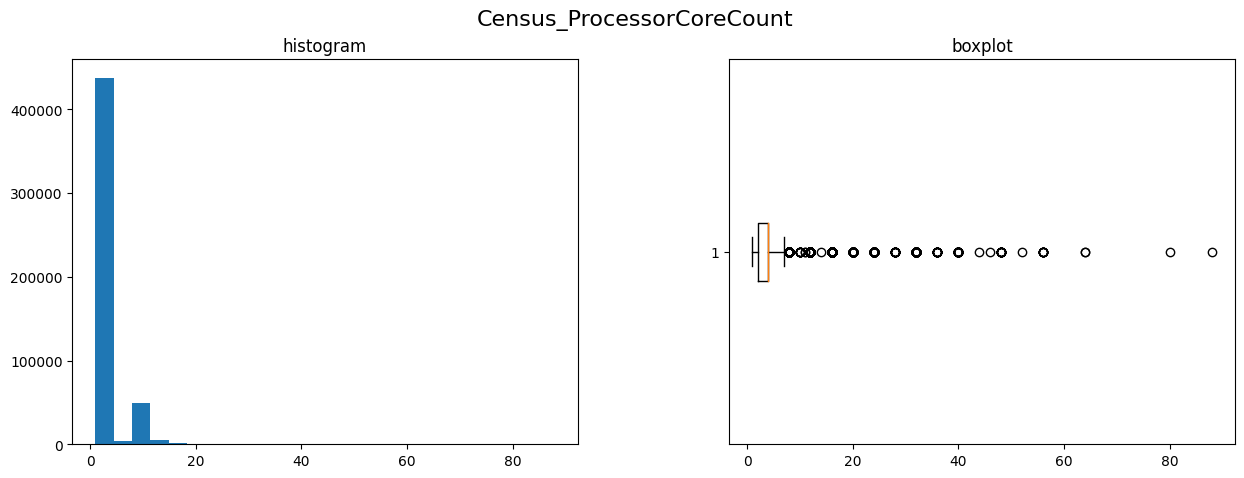

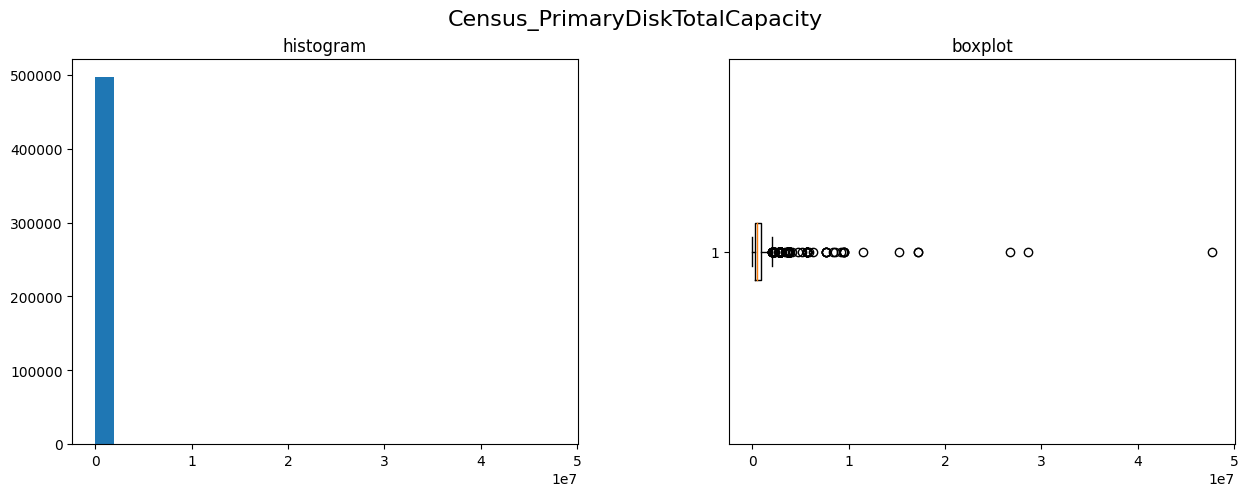

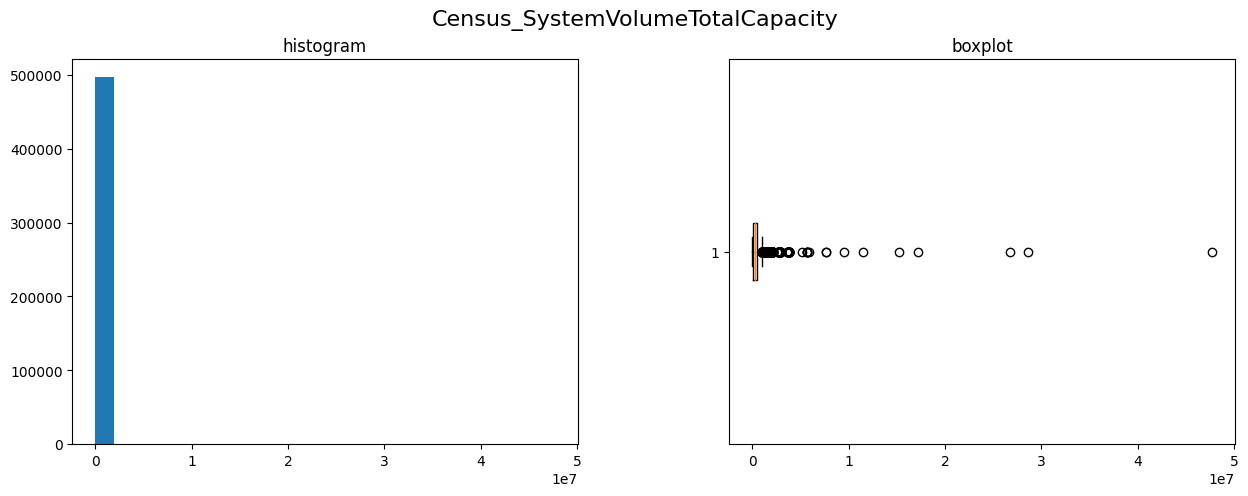

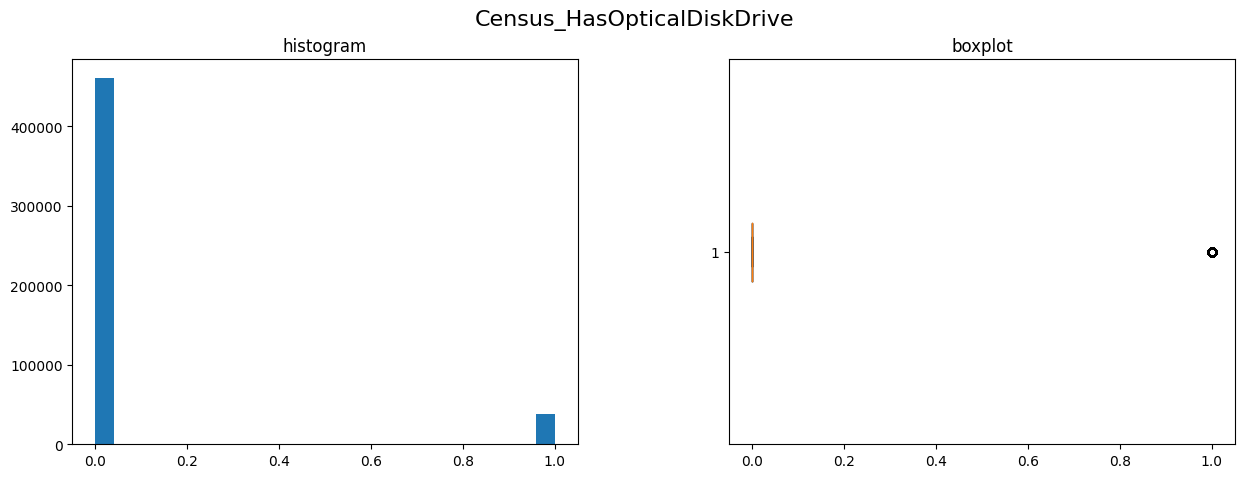

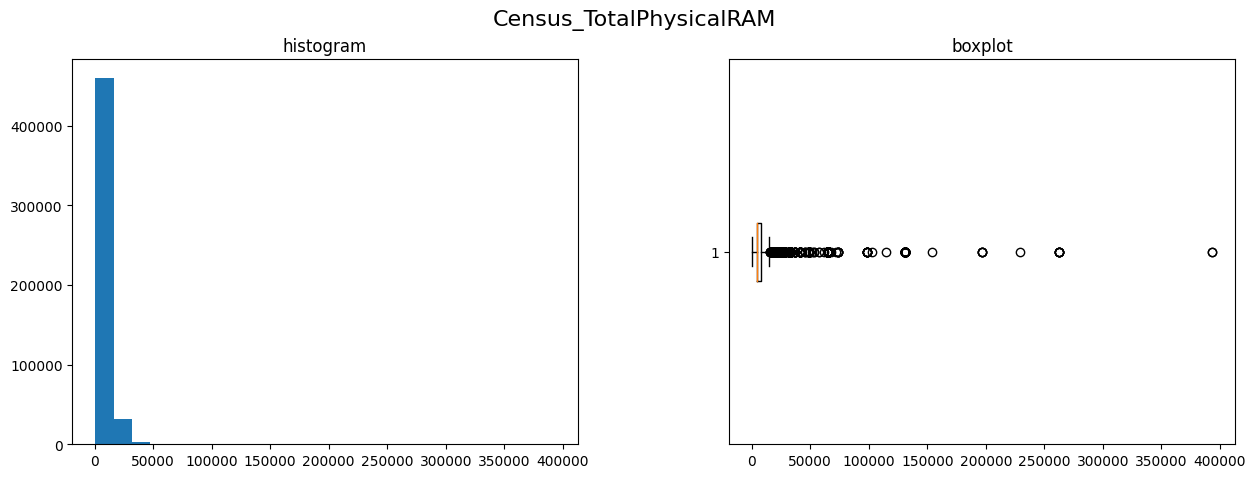

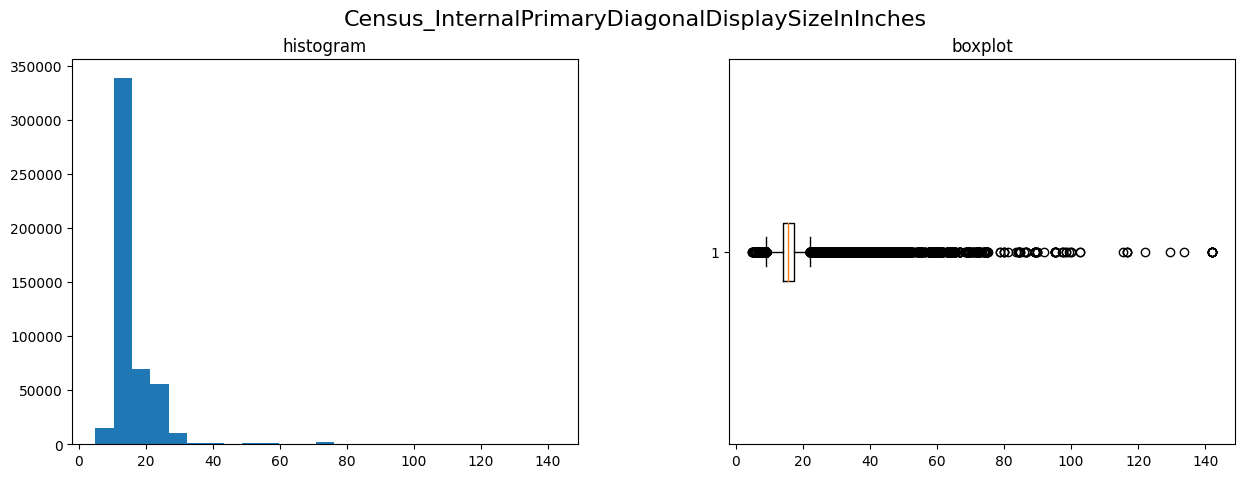

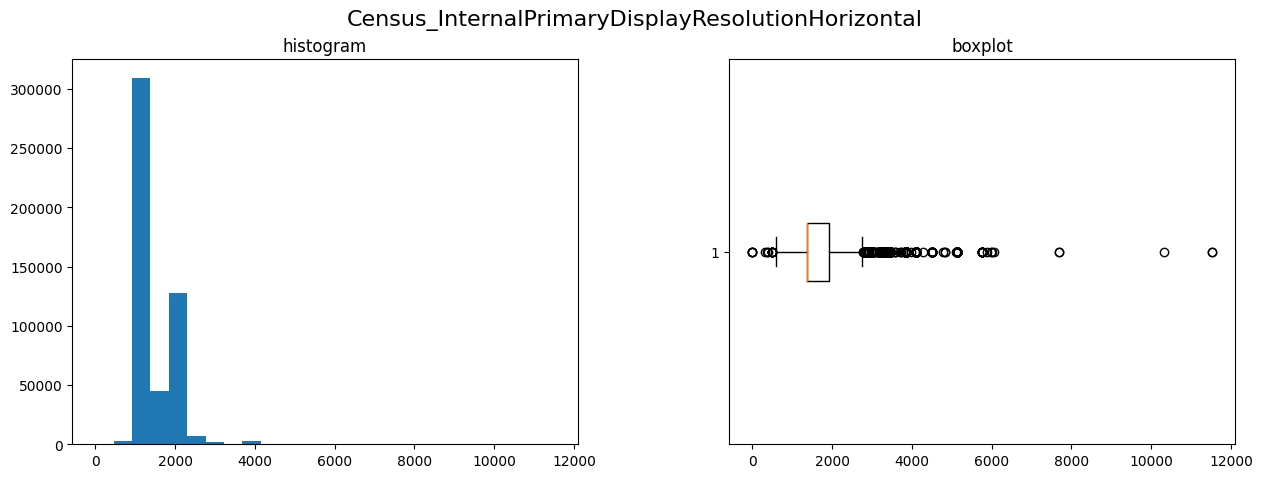

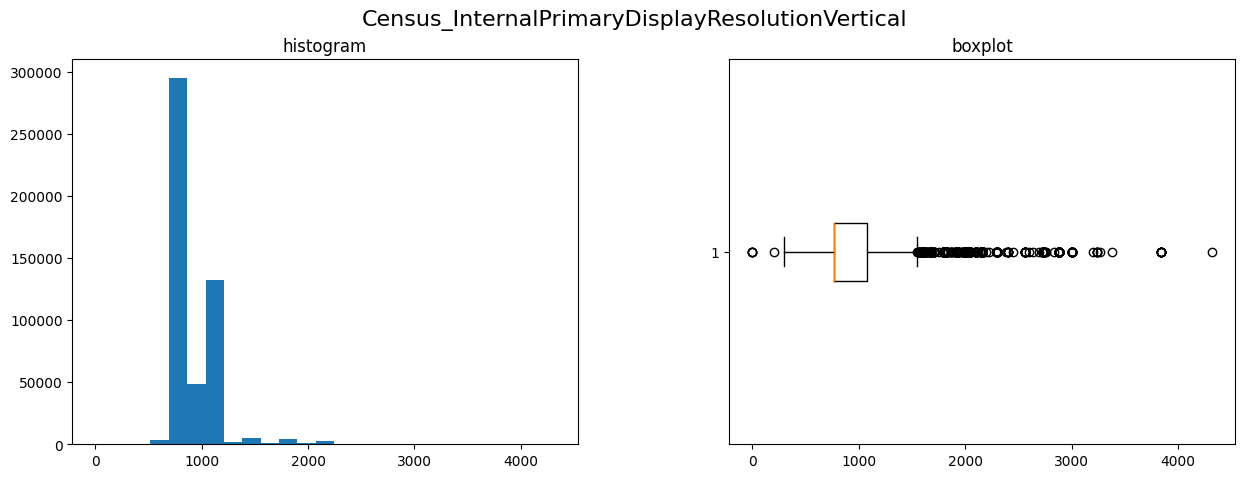

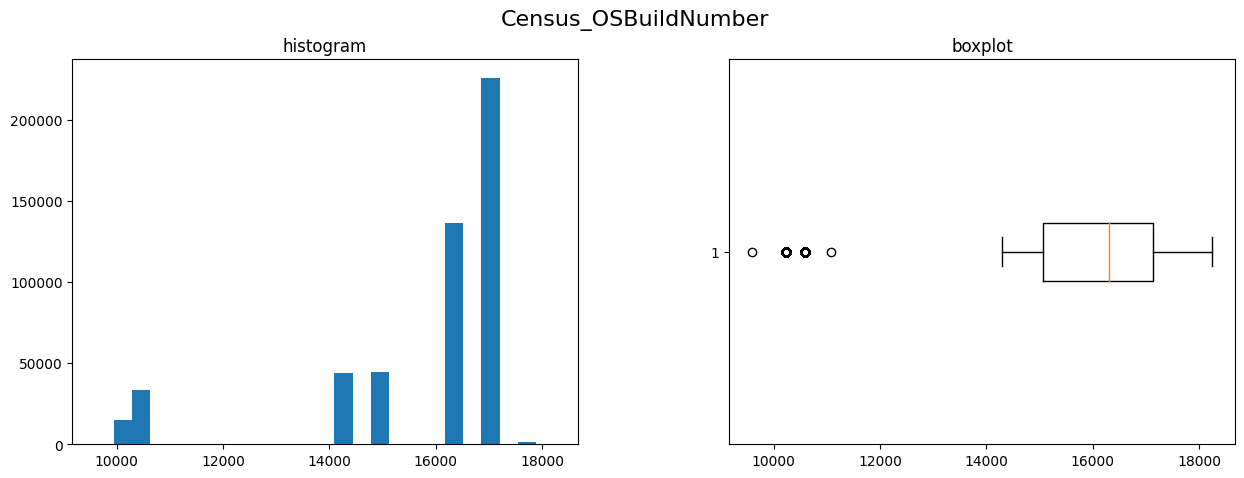

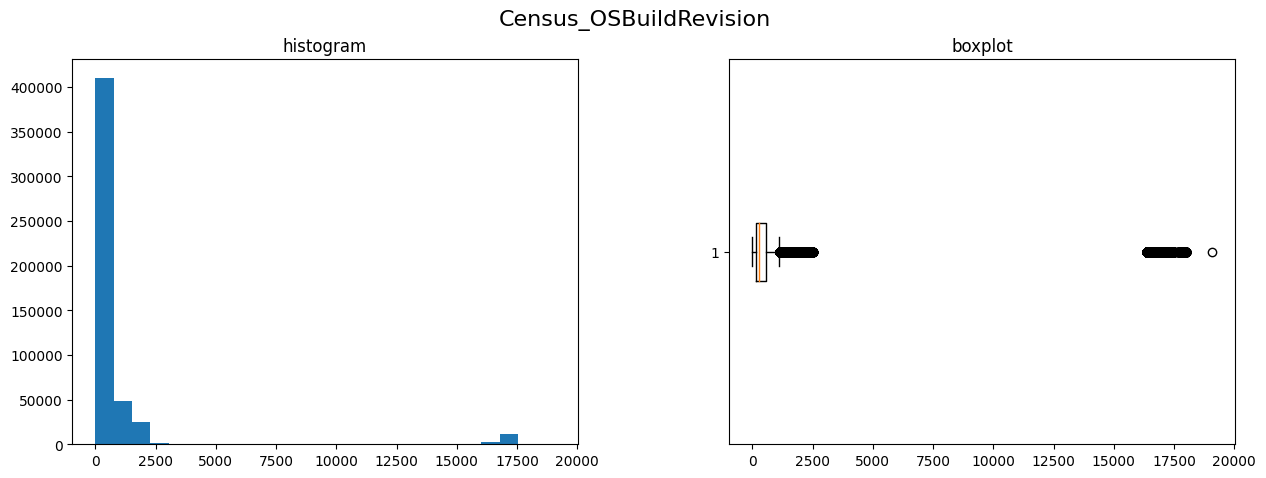

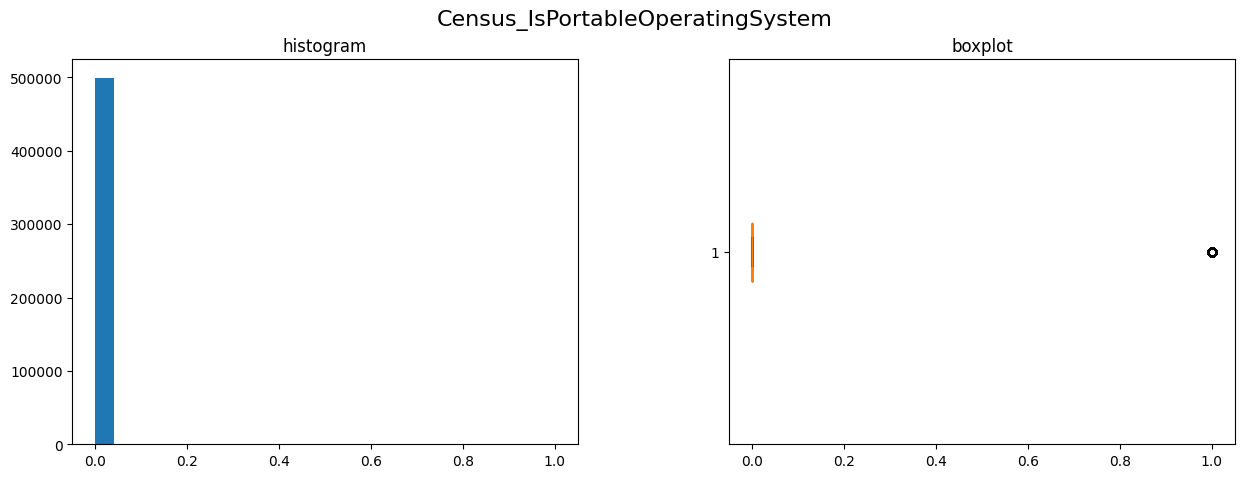

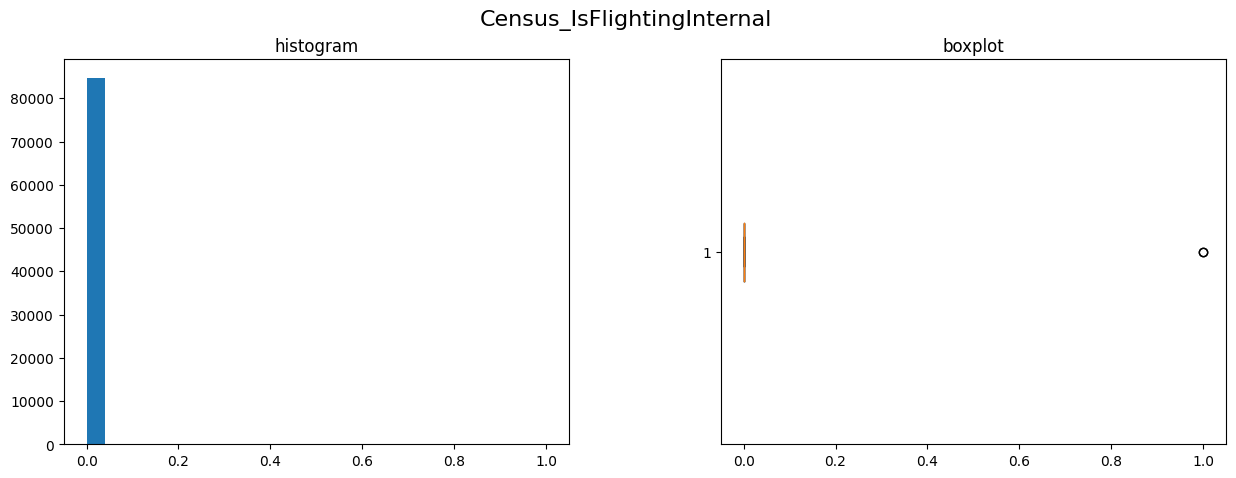

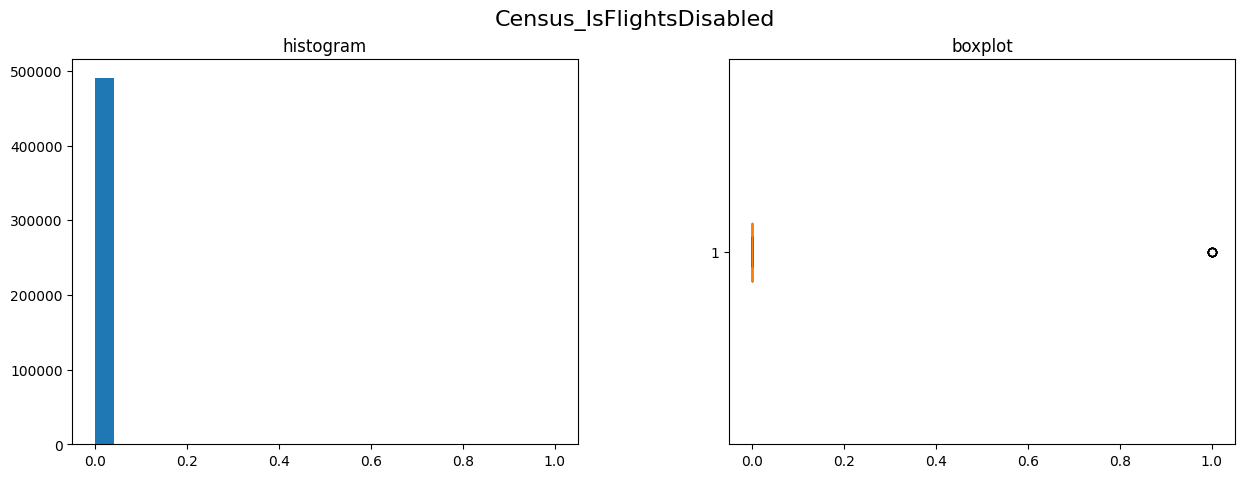

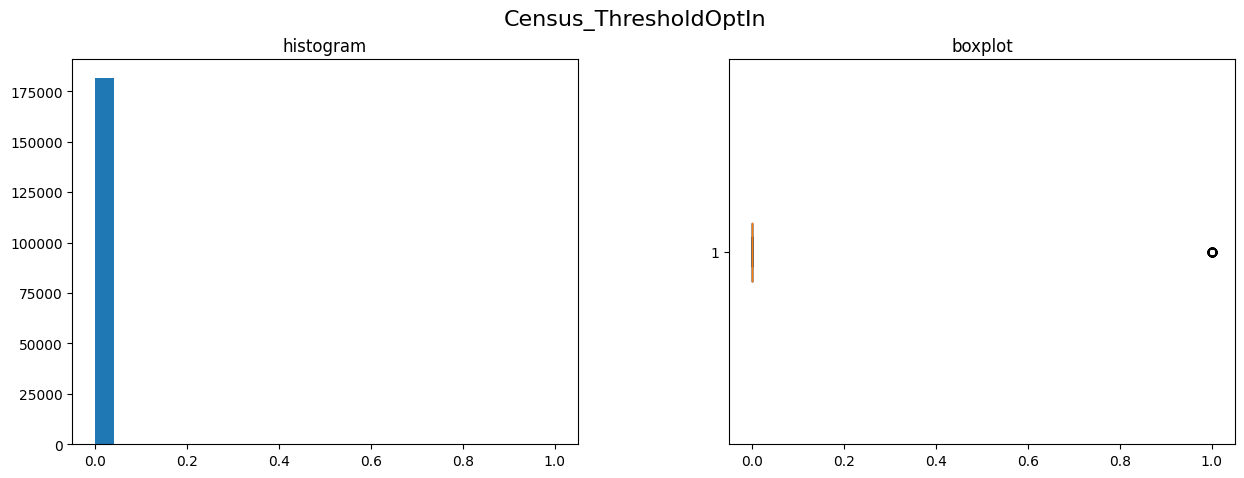

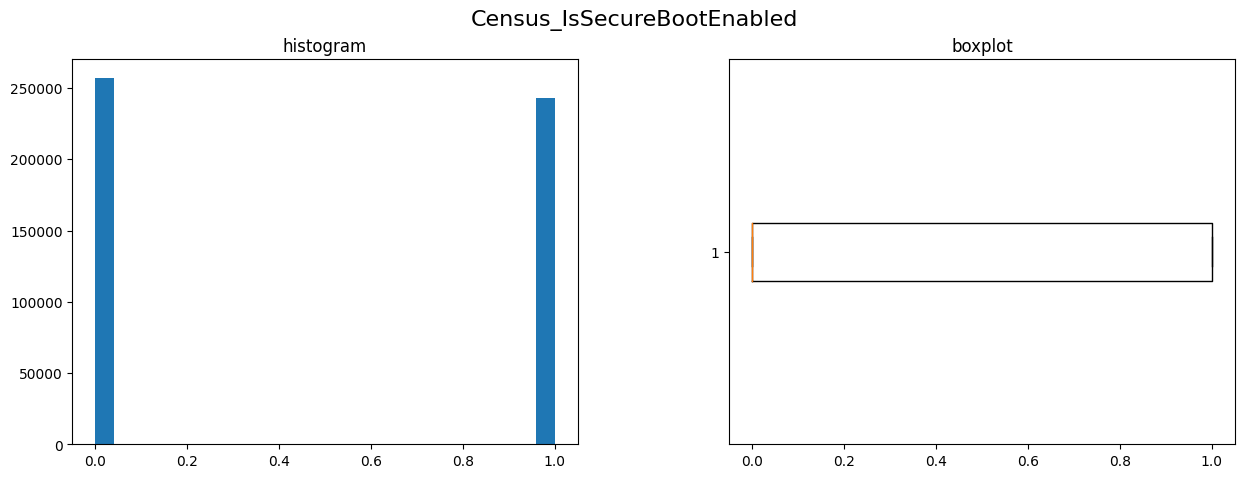

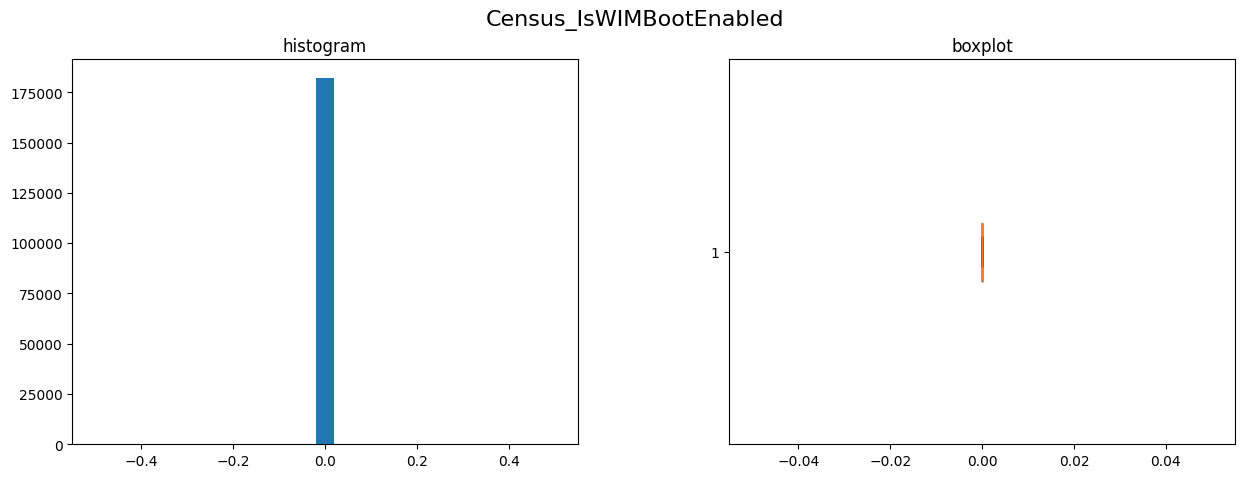

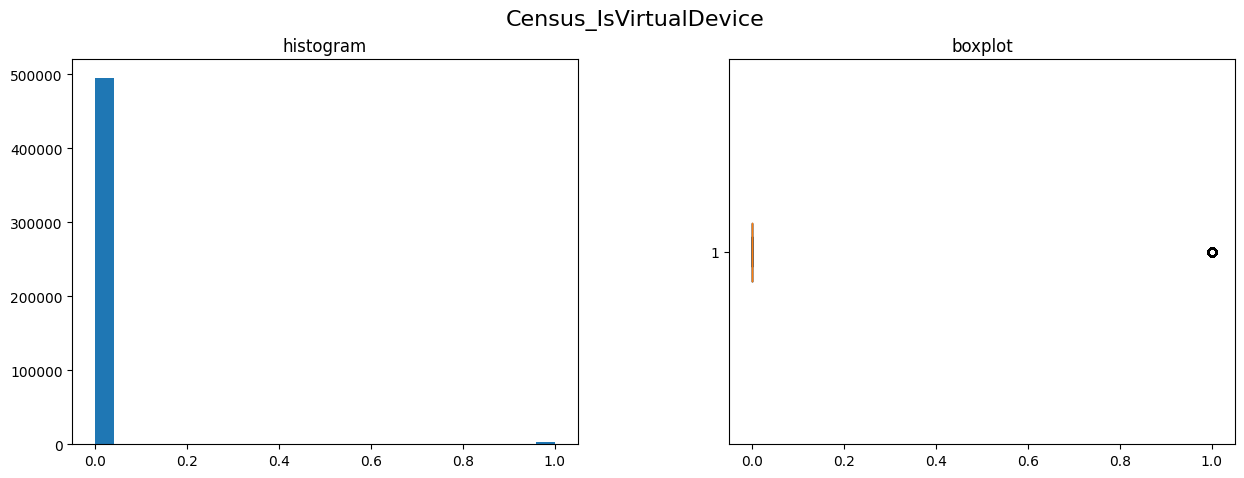

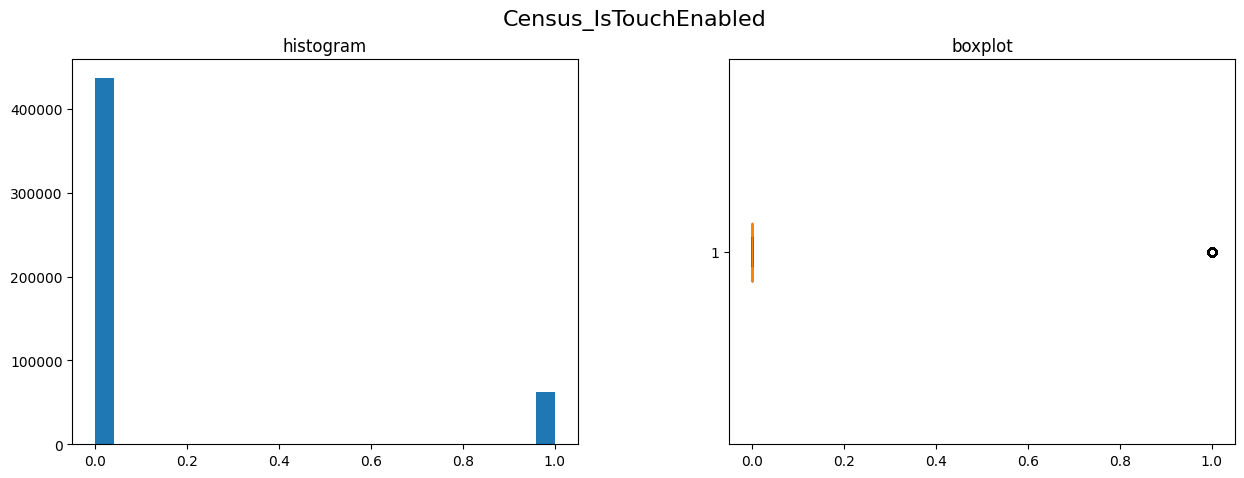

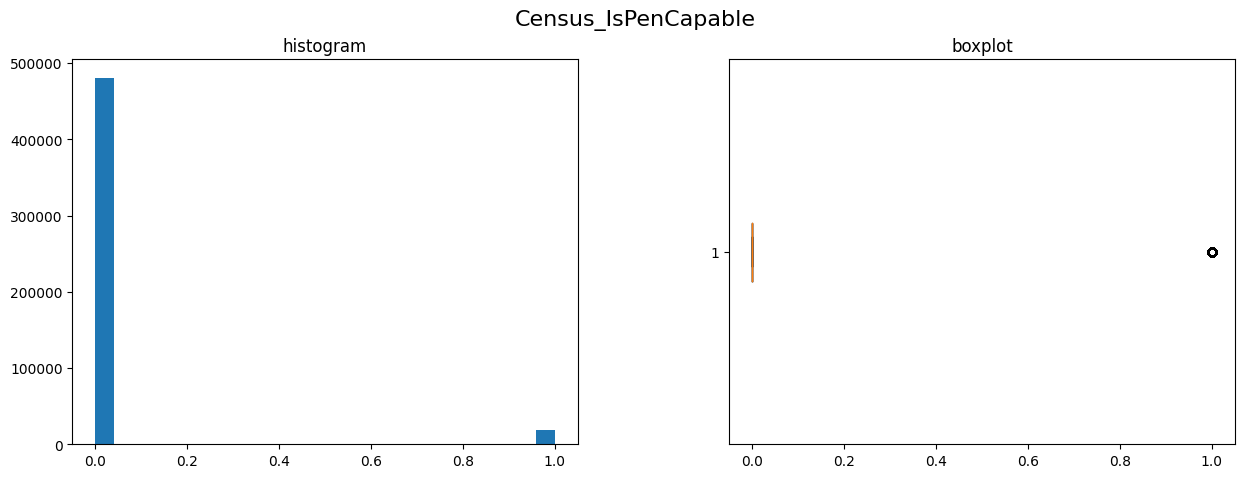

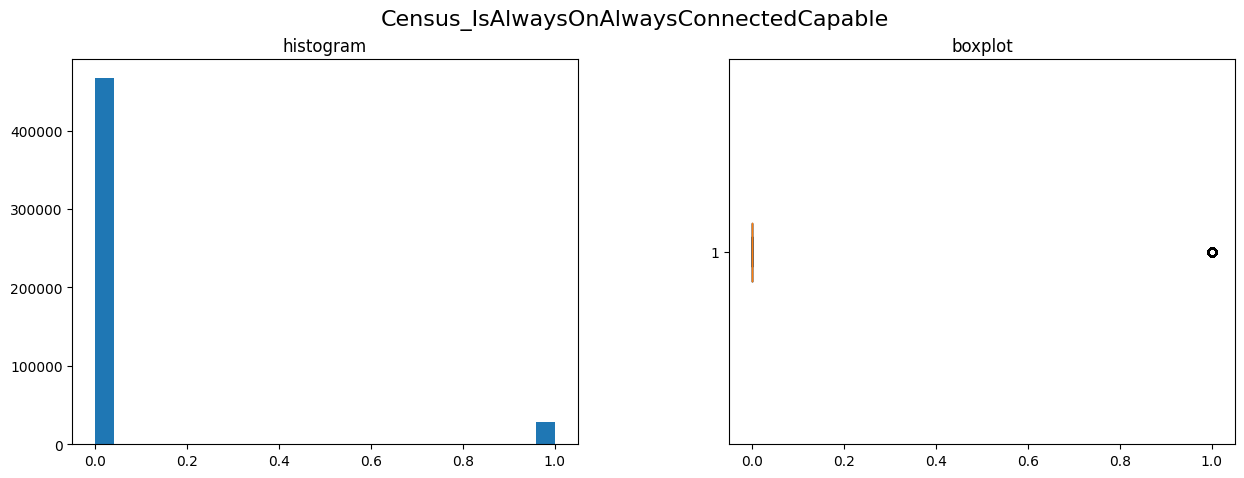

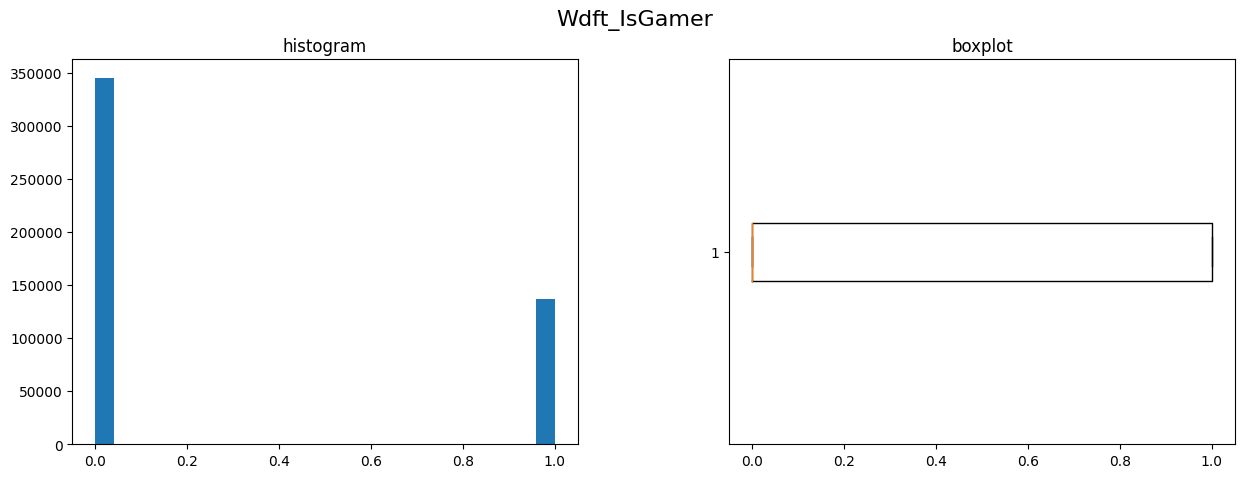

In [29]:
for c in numeric_cols:
    plot_histogram_and_boxplot(df = df, column_name = c)

### 2. Categorical

In [30]:
def plot_barplot(df, column_name):
    """Plots the barplot of a categorical variable.

    Parameters:
    column_name (str): Categorical variable's name

    Returns:
    None
    """
    fig = plt.figure()
    fig.suptitle(column_name, fontsize=16)
    df[column_name].value_counts().plot(kind = 'bar')

In [31]:
for c in categoric_cols:
    plot_barplot(df, column_name = c)

Output hidden; open in https://colab.research.google.com to view.

## Part II. Bivariant

### 1. Numerical

Defino una función para ver la distribución de las variables numéricas en función de la variable objetivo.

In [34]:
def num_variable_objetivo(variable):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    df.loc[df['HasDetections'] == 0, variable].hist(ax=ax, alpha=0.5)
    df.loc[df['HasDetections'] == 1, variable].hist(ax=ax, alpha=0.5)
    ax.legend(['NoDetection(0)', 'HasDetection(1)'])
    plt.title(f'Distribución de {variable} y la variable objetivo')

<ipython-input-34-b340e6eba974>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(8, 4))


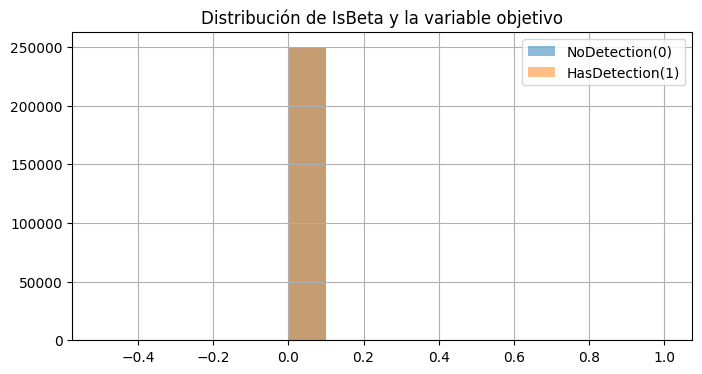

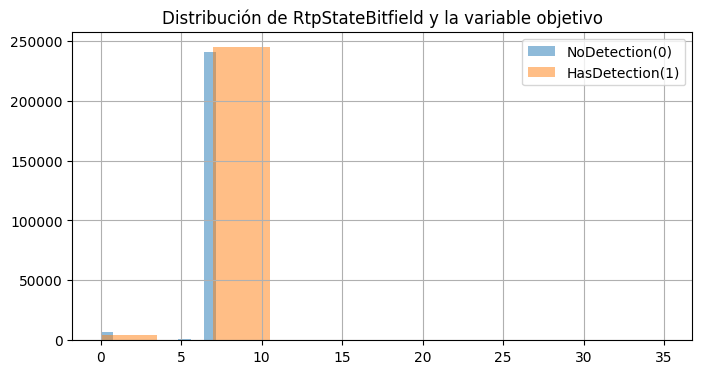

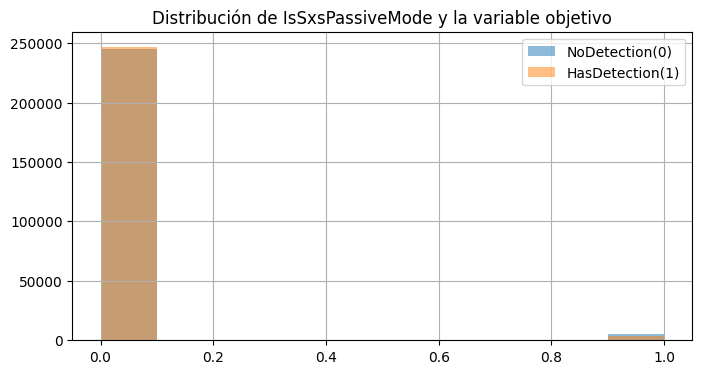

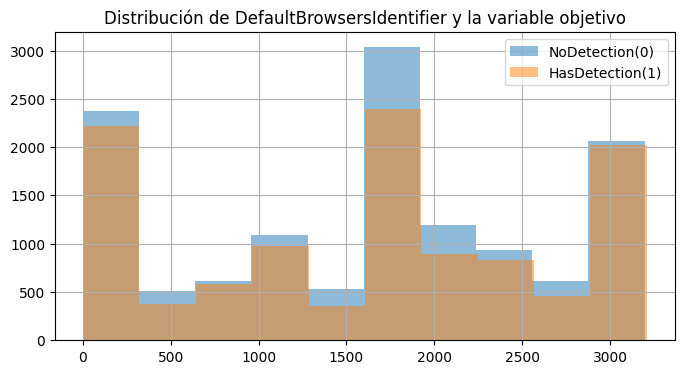

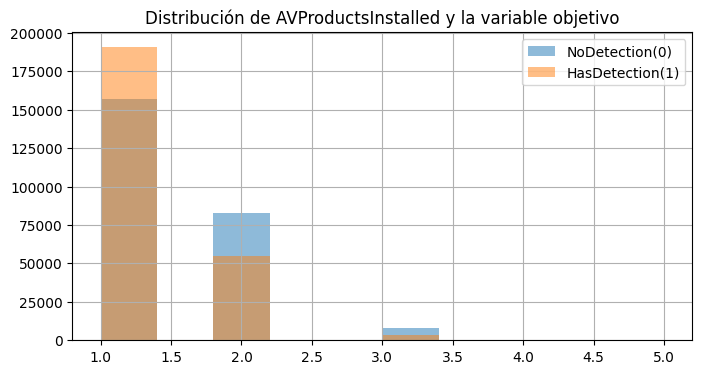

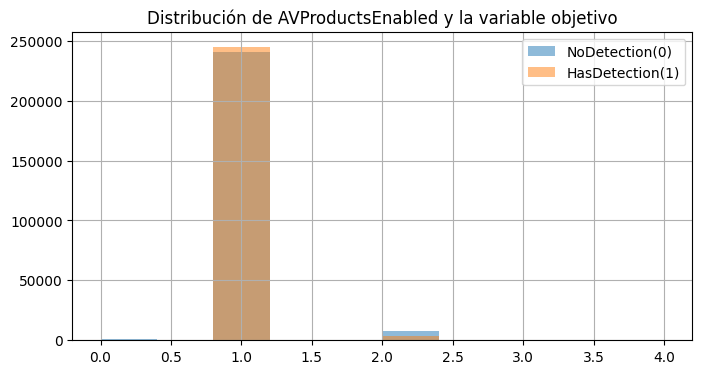

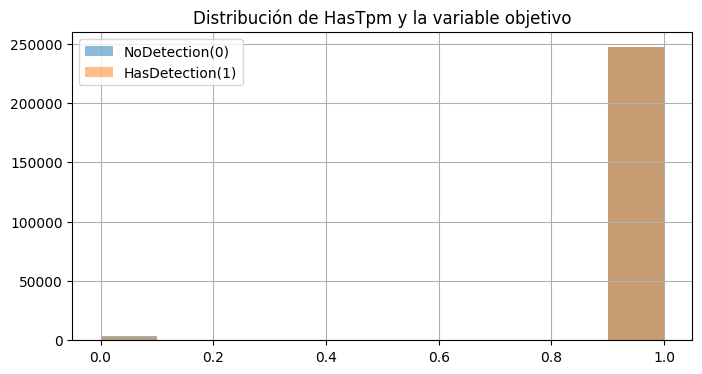

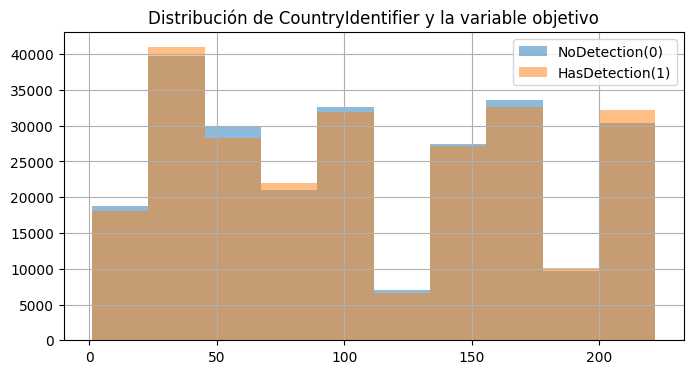

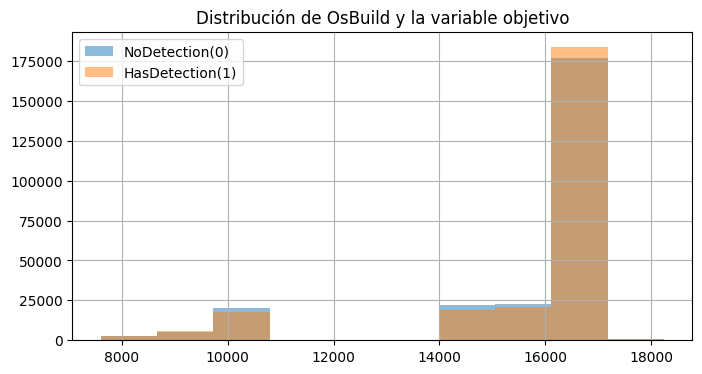

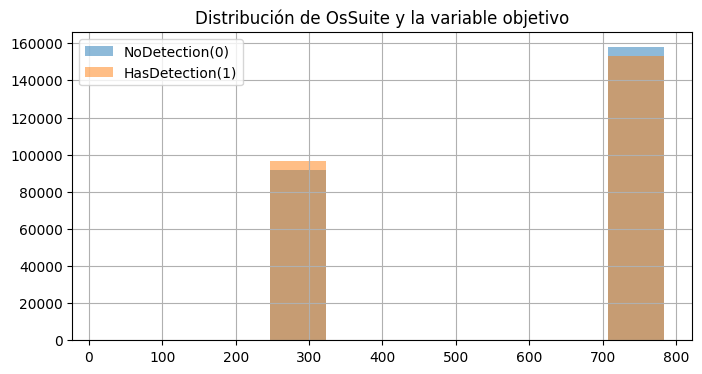

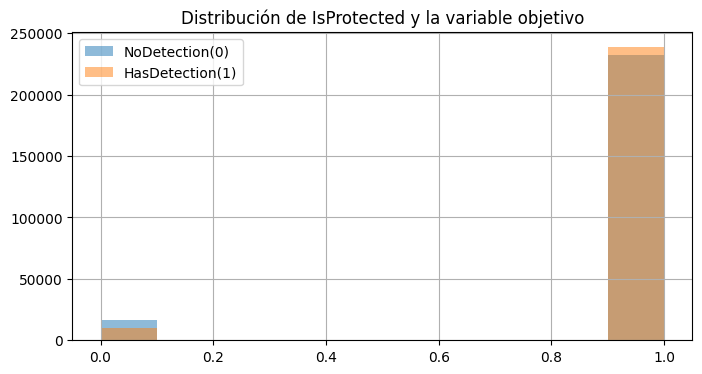

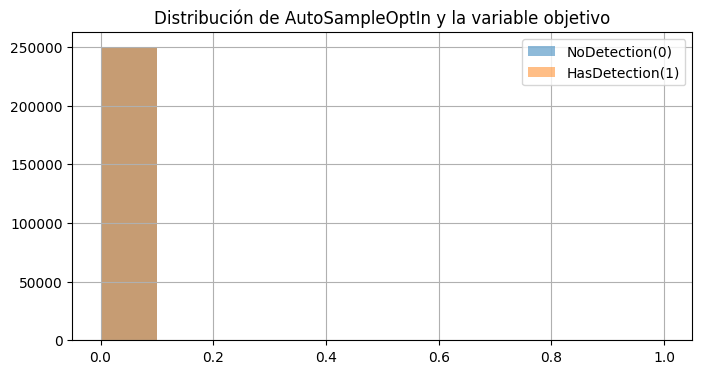

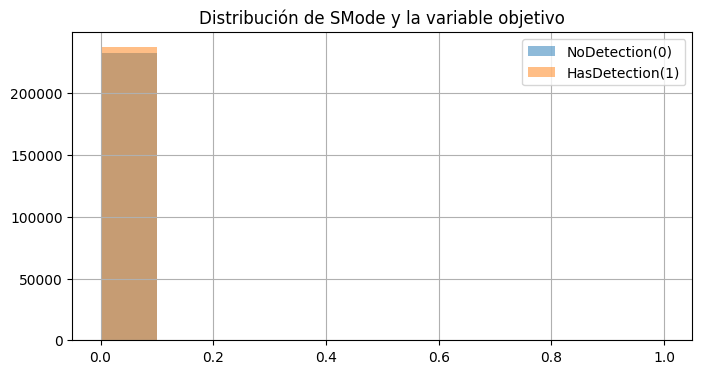

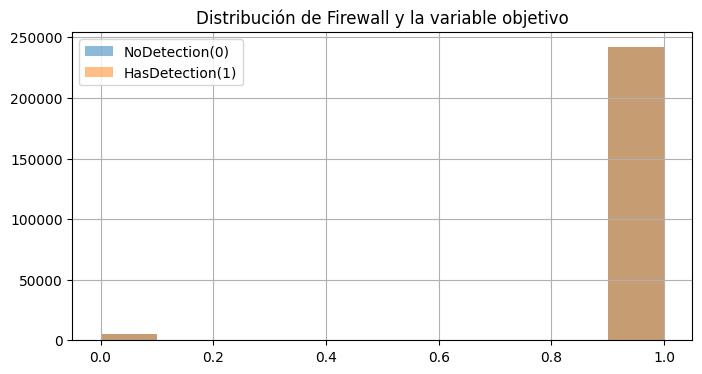

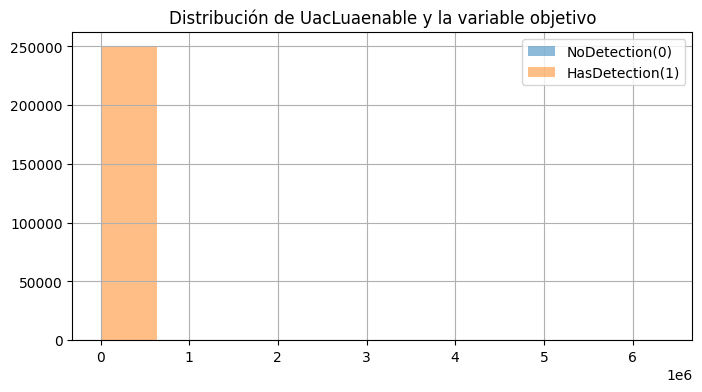

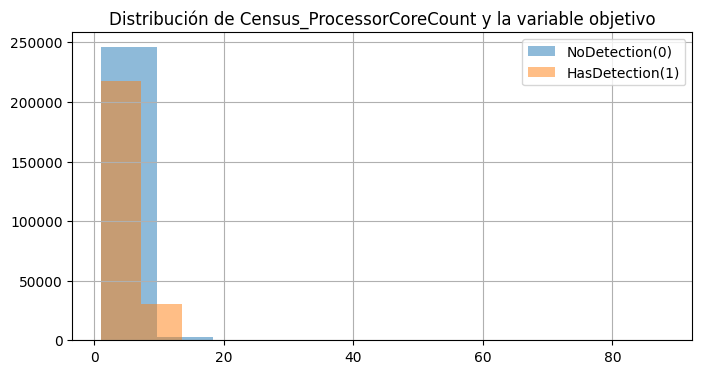

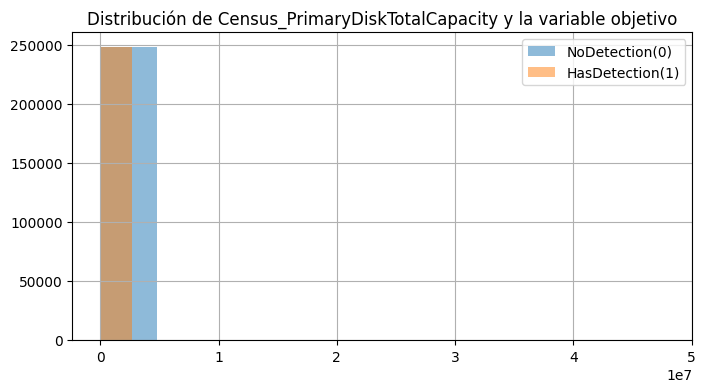

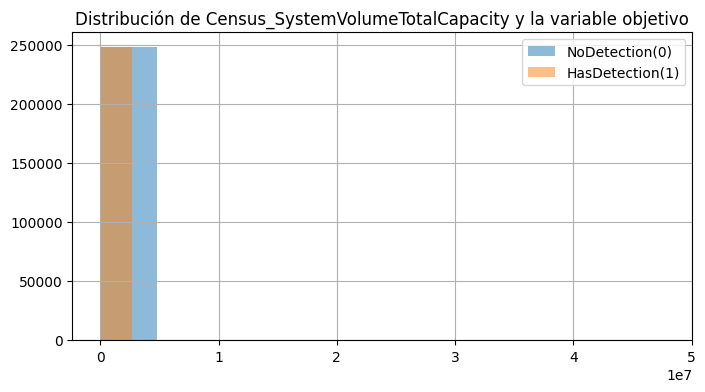

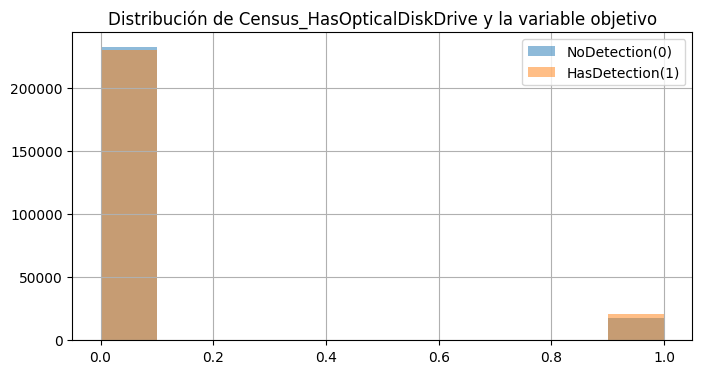

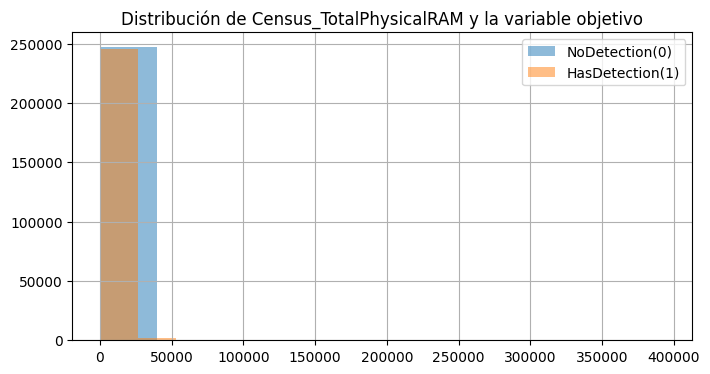

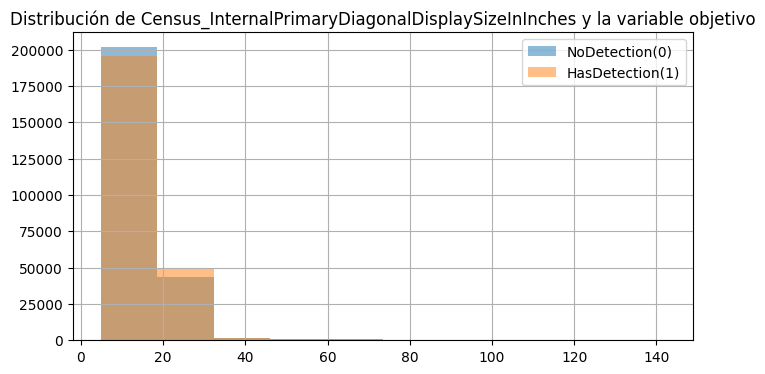

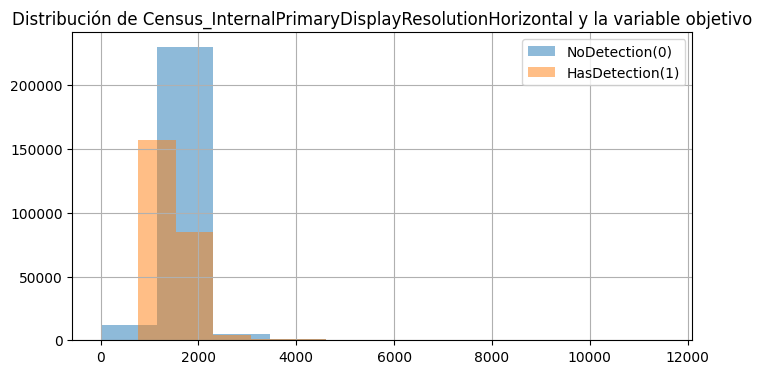

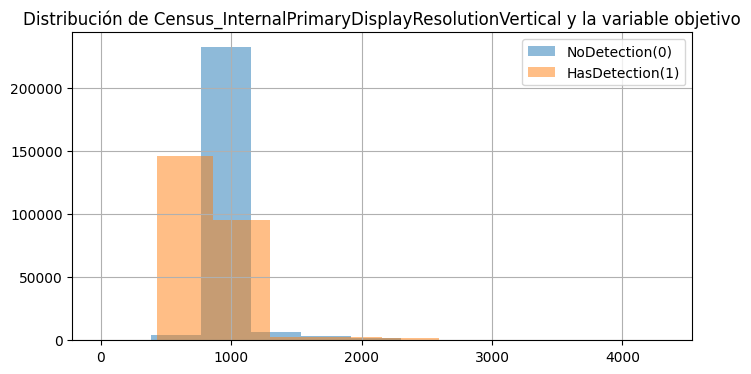

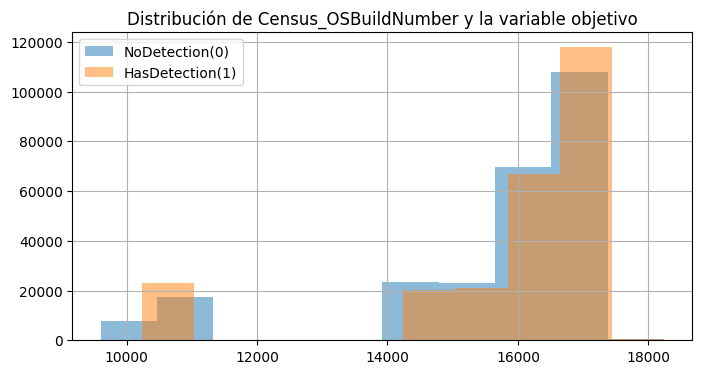

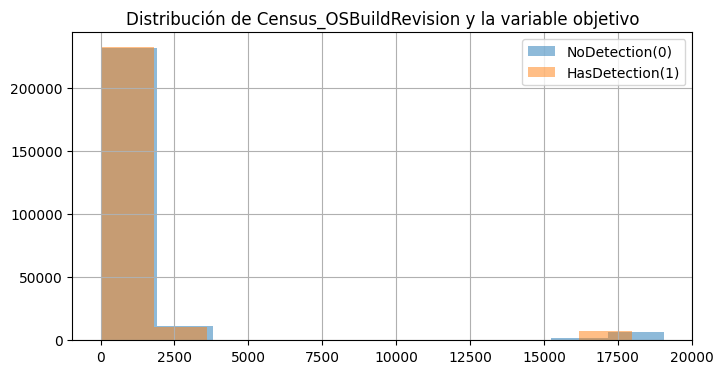

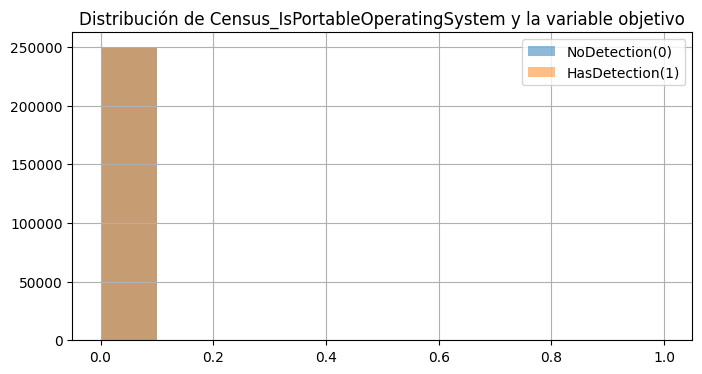

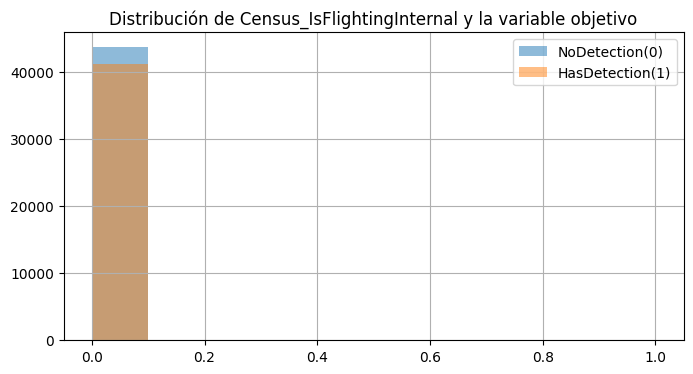

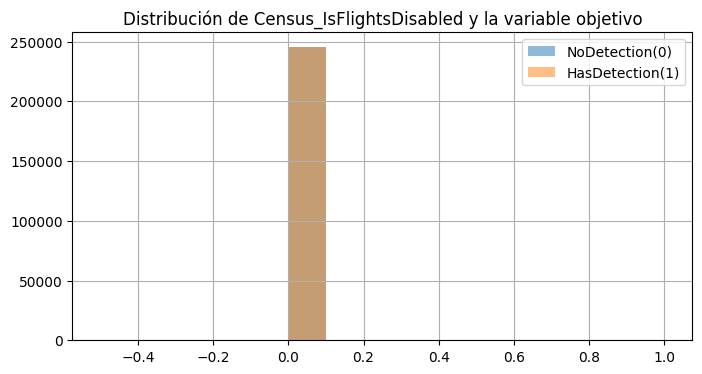

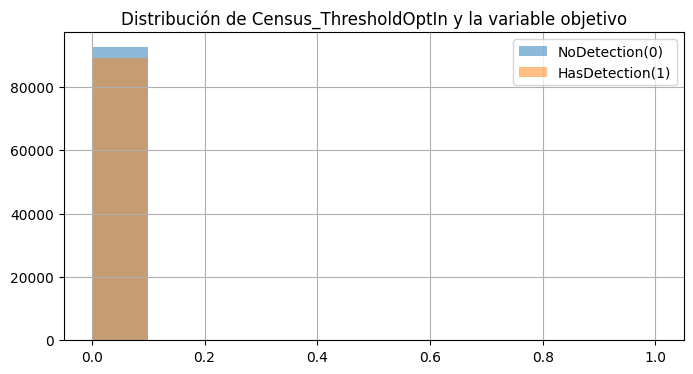

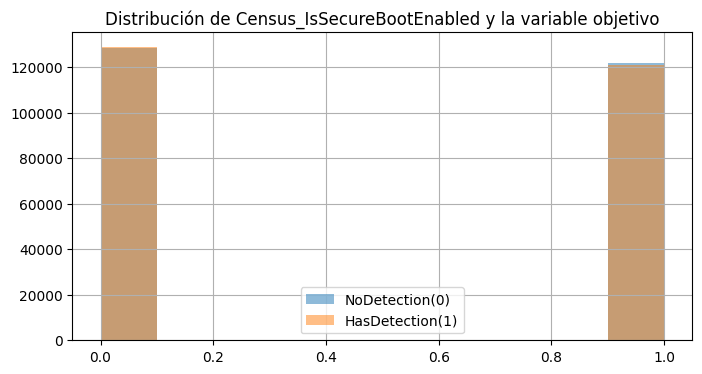

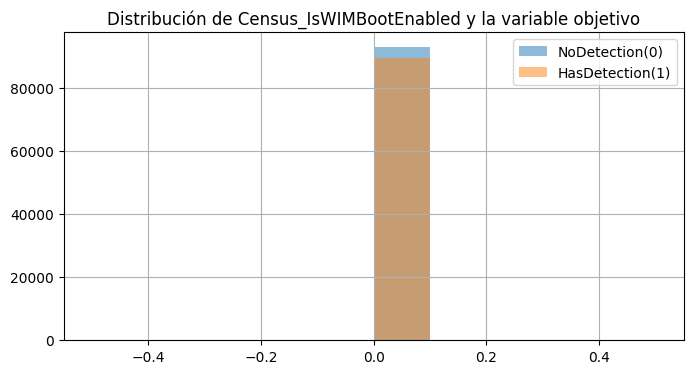

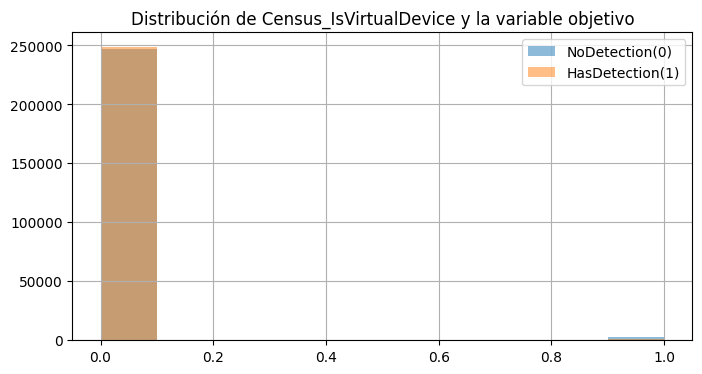

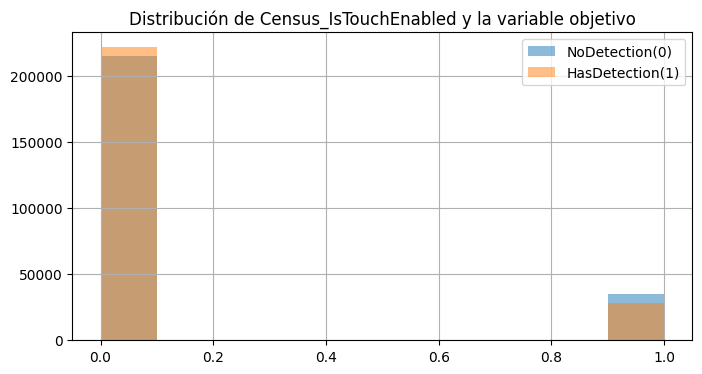

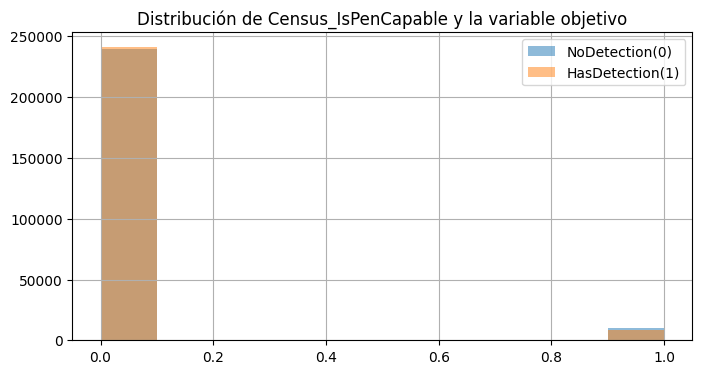

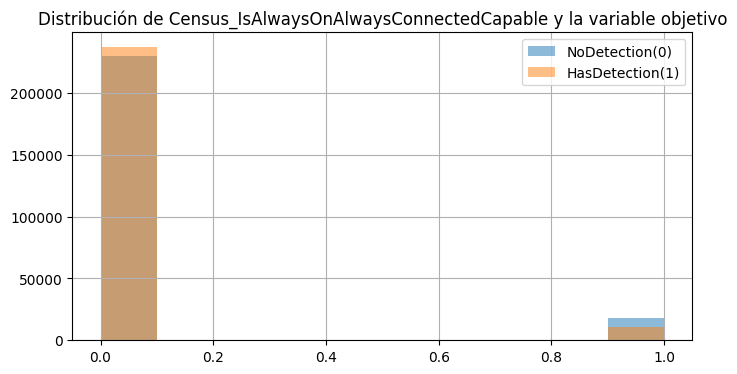

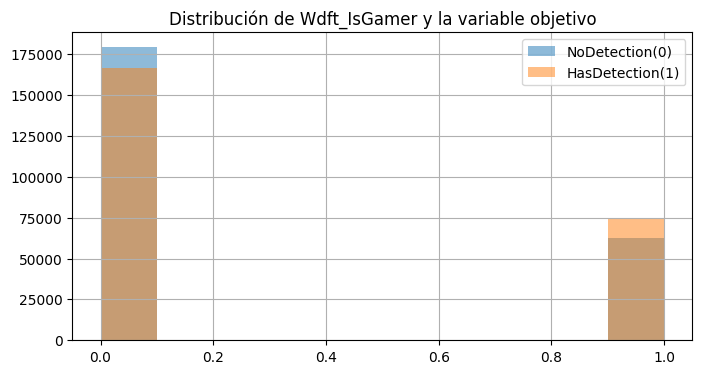

In [35]:
for variable in numeric_cols:
    num_variable_objetivo(variable)

### 2. Categorical

Defining a function to see the distribution of categorical variables in terms of the target.

In [36]:
def cat_variable_objetivo(variable):
    sns.countplot(x=variable, hue='HasDetections', data=df, alpha=0.5)
    plt.title(f'Distribución de {variable} y la variable objetivo')
    return plt.show()

In [37]:
# categorical variables excluding id_cols
categoric_cols = df.select_dtypes(include=['category']).columns.tolist()
categoric_cols = [c for c in categoric_cols if c not in id_cols]  # List comprehension
print("Categorical variables: ", categoric_cols)

Categorical variables:  ['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'Platform', 'Processor', 'OsVer', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'PuaMode', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_DeviceFamily', 'Census_ProcessorClass', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_InternalBatteryType', 'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing']


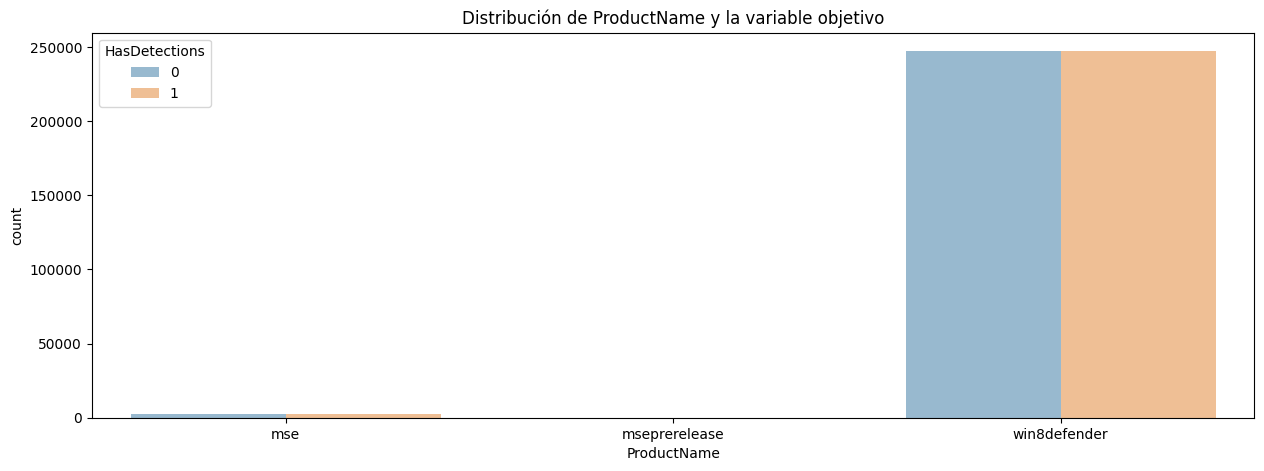

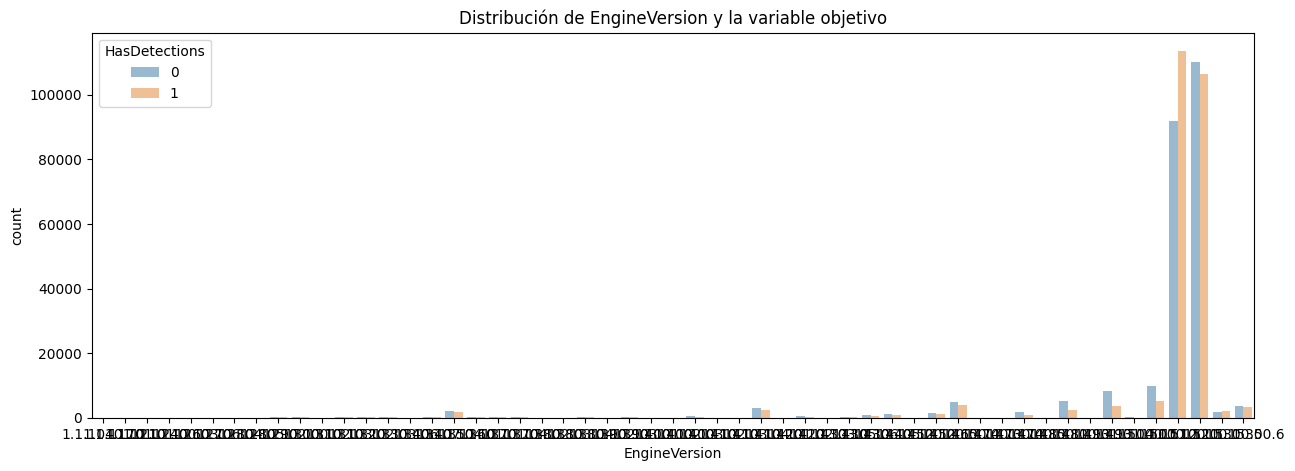

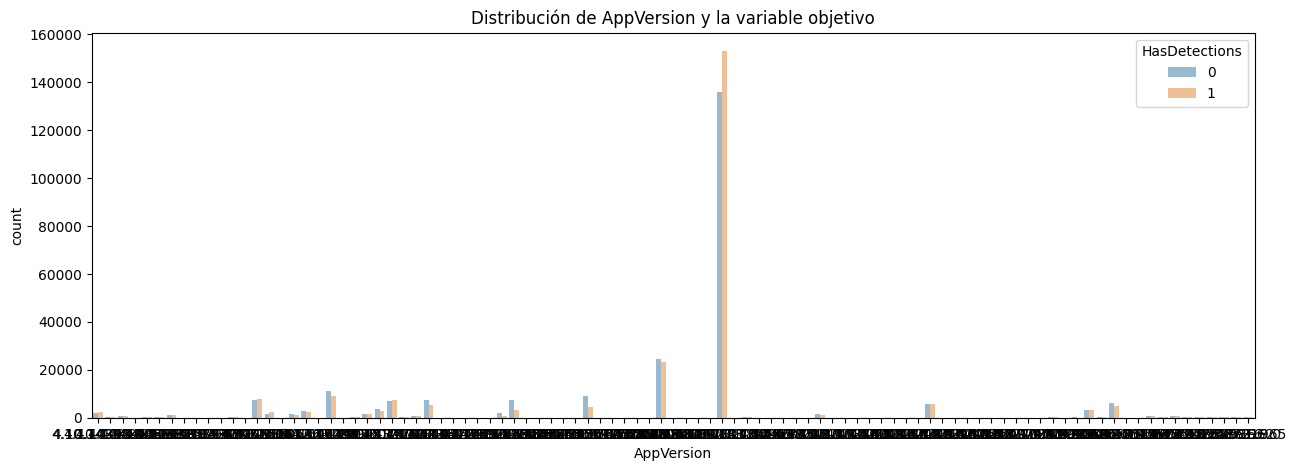

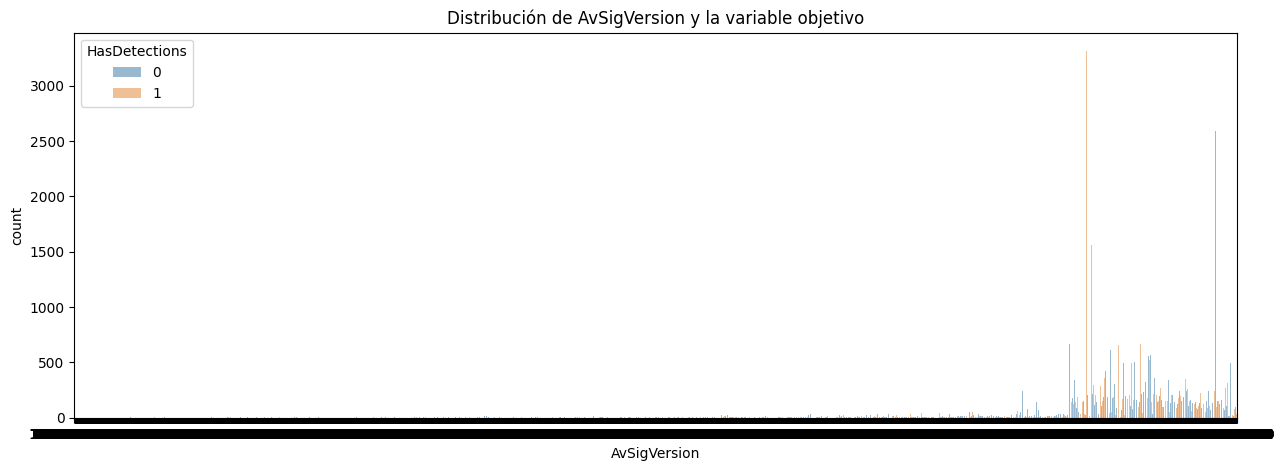

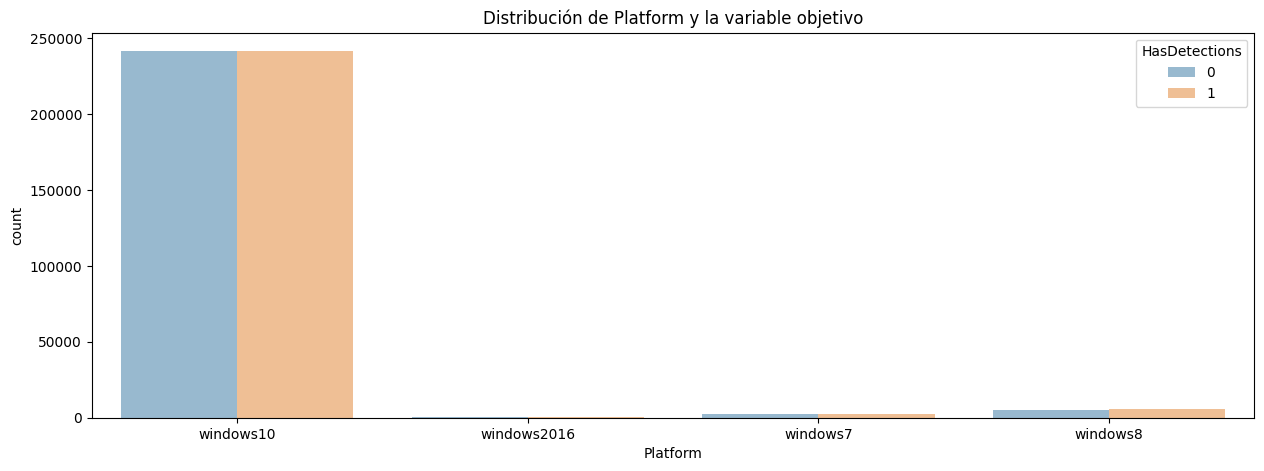

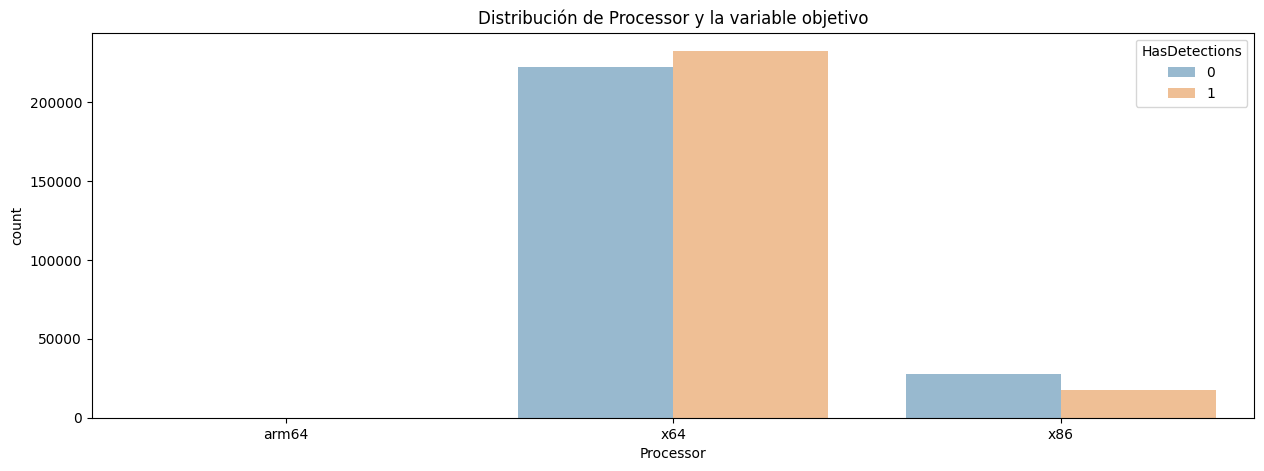

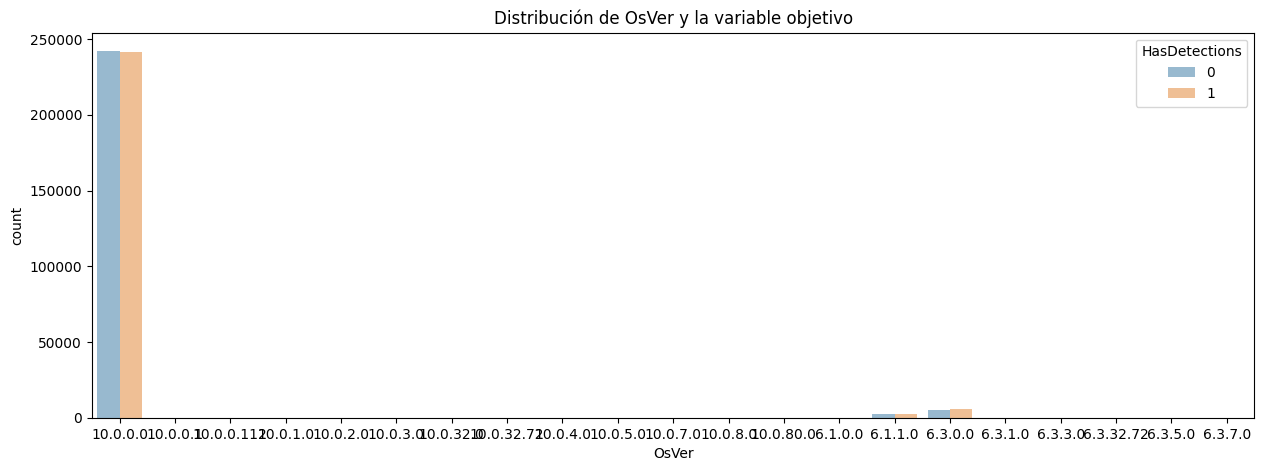

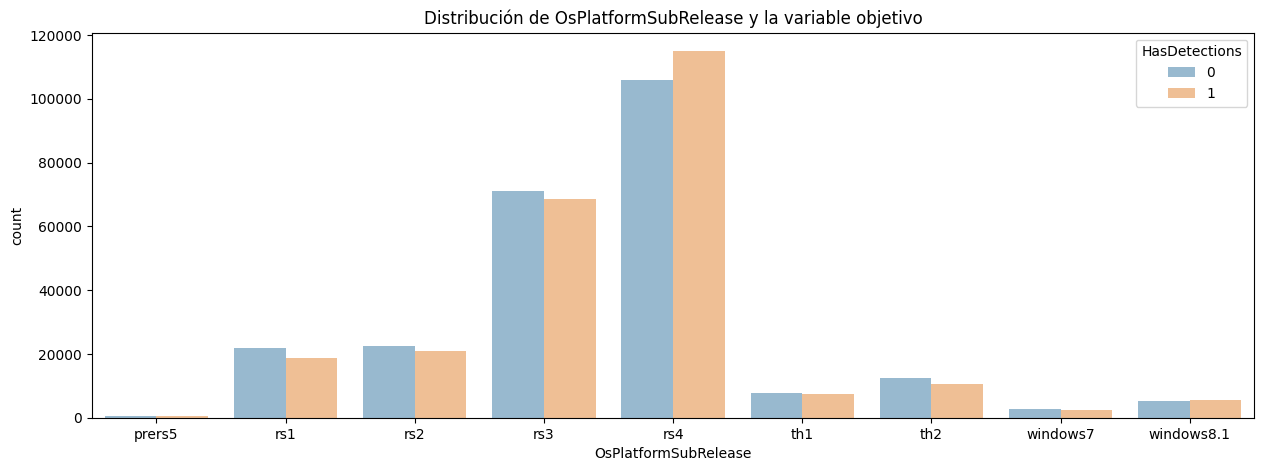

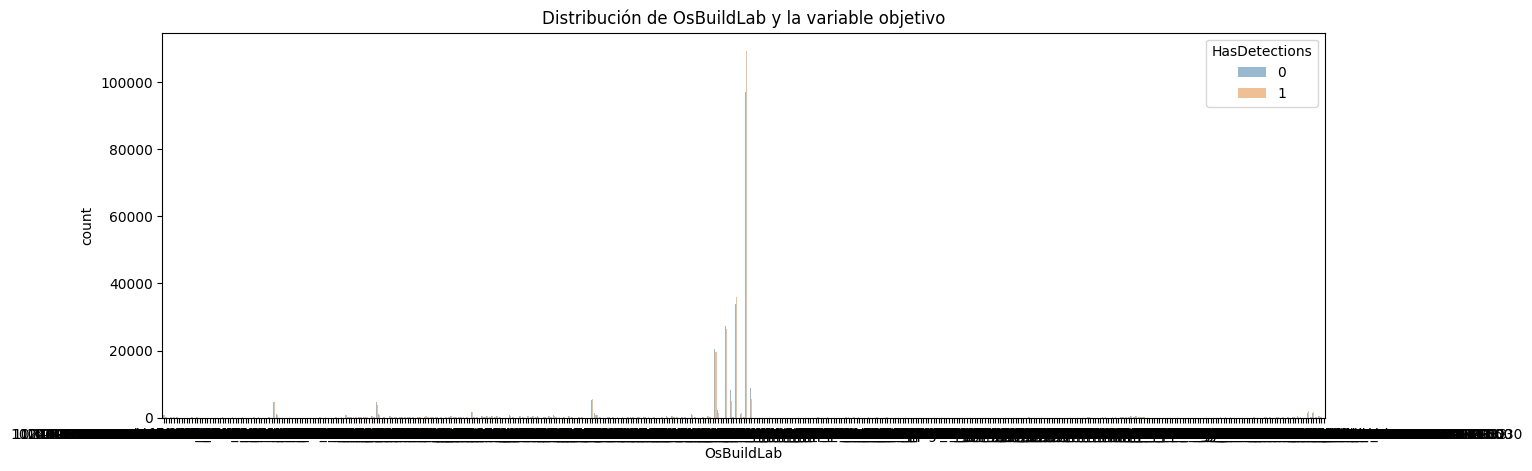

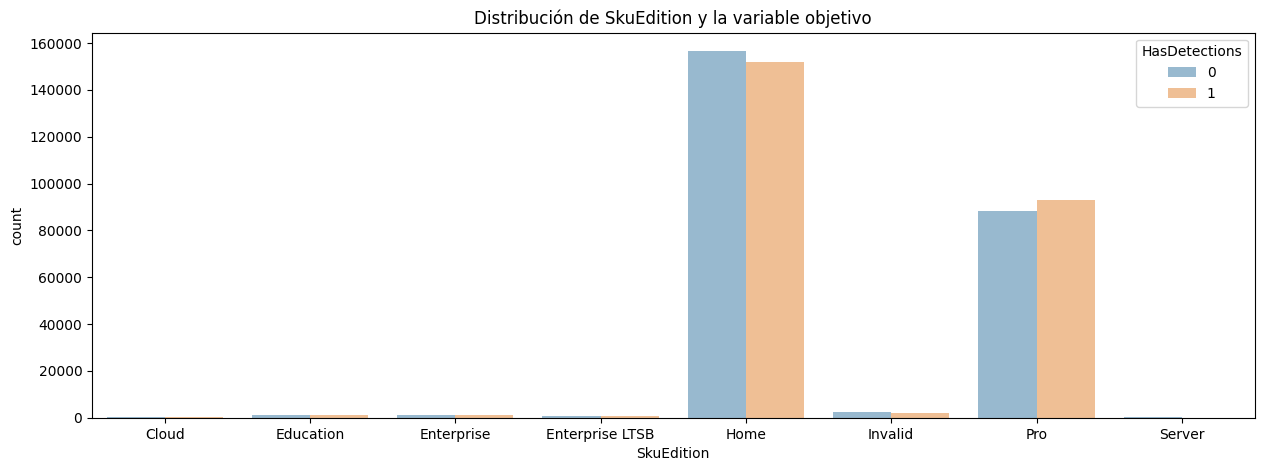

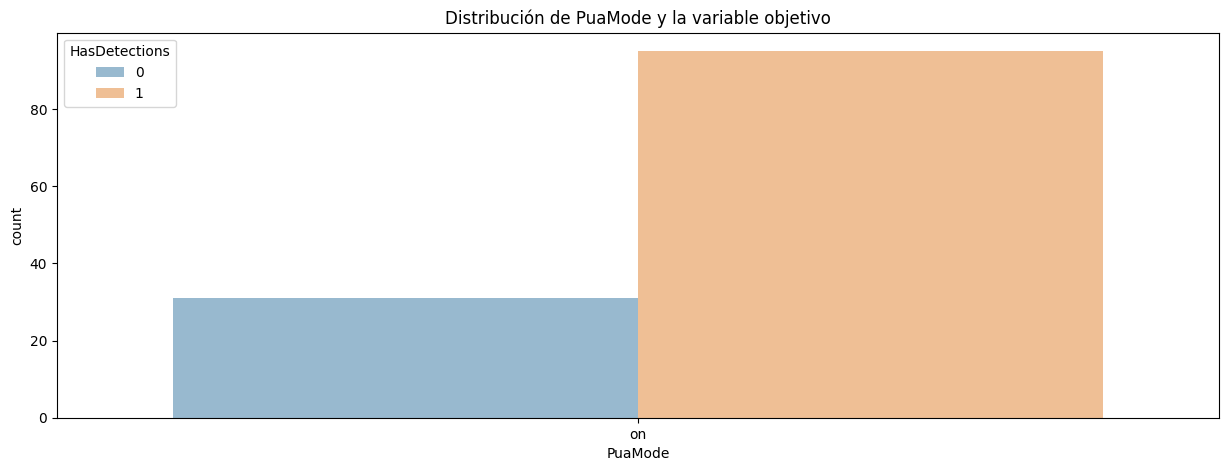

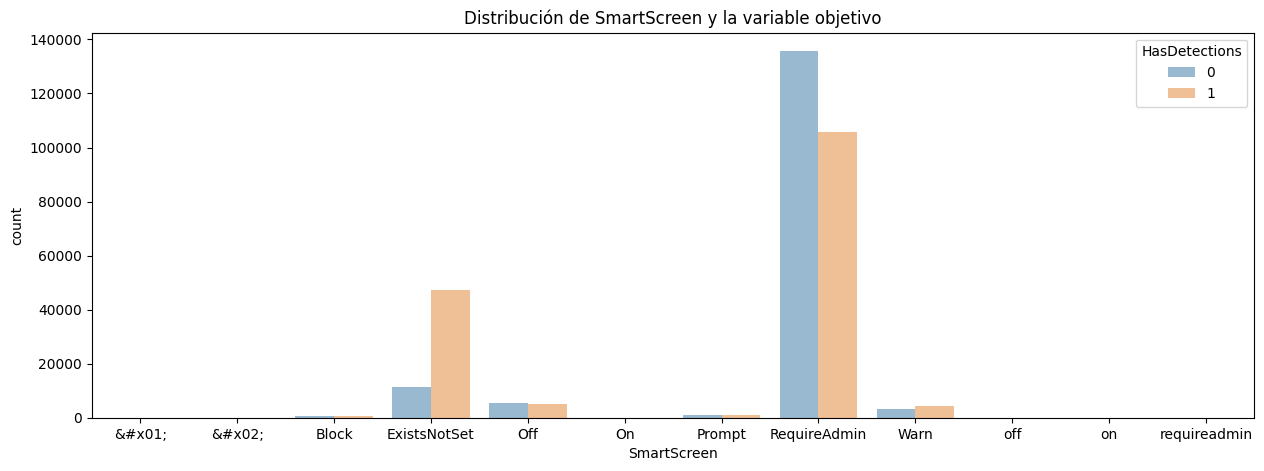

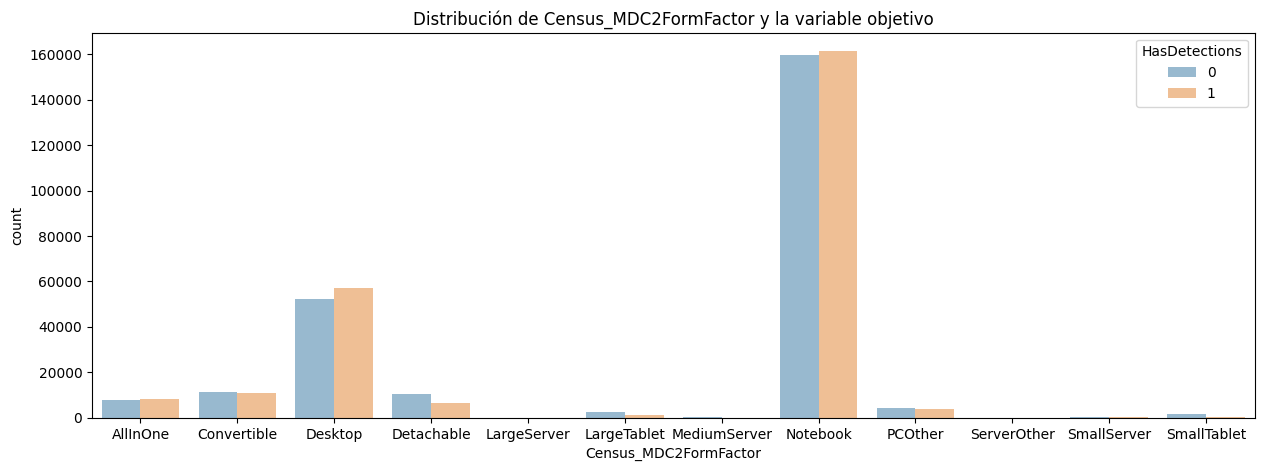

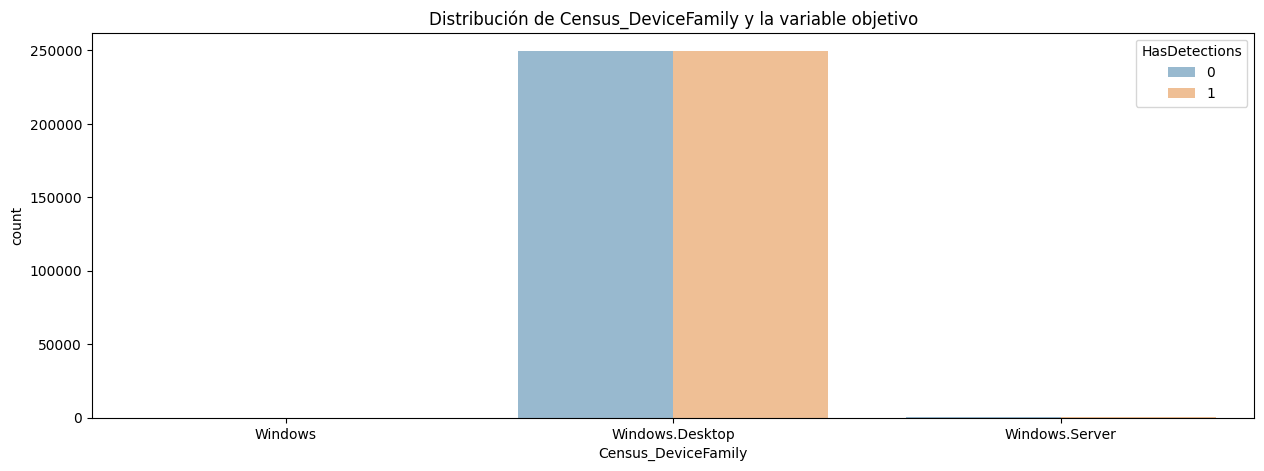

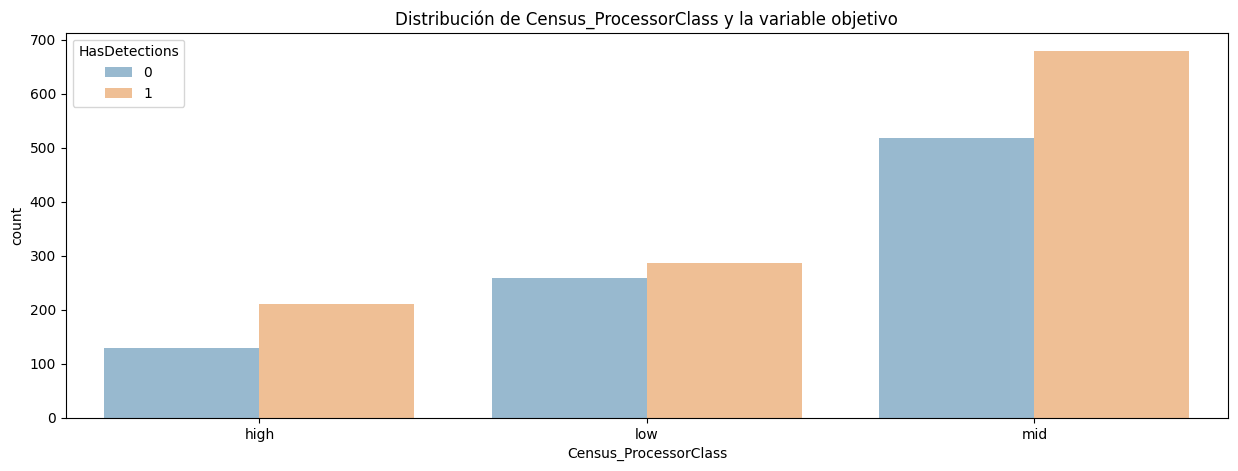

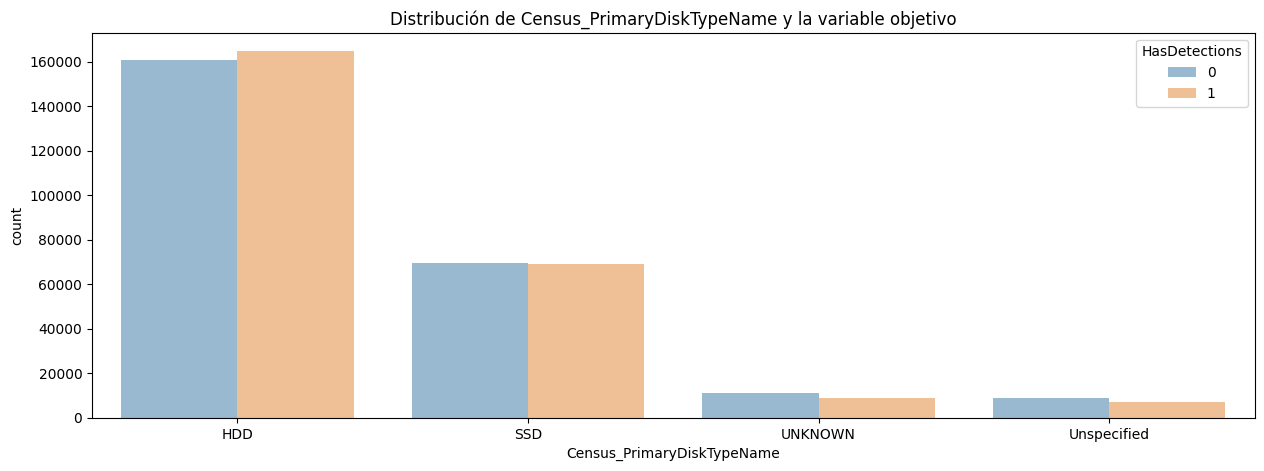

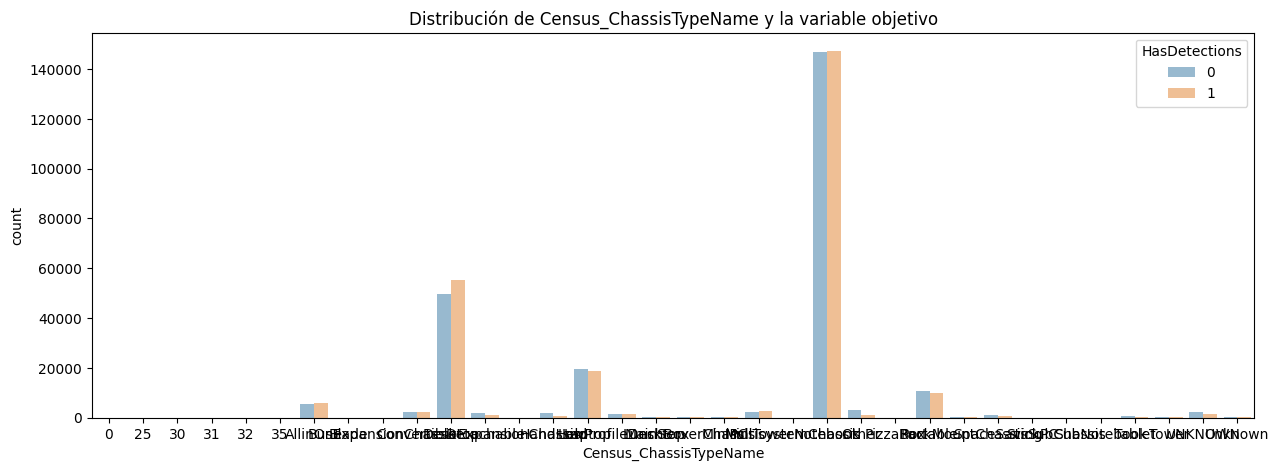

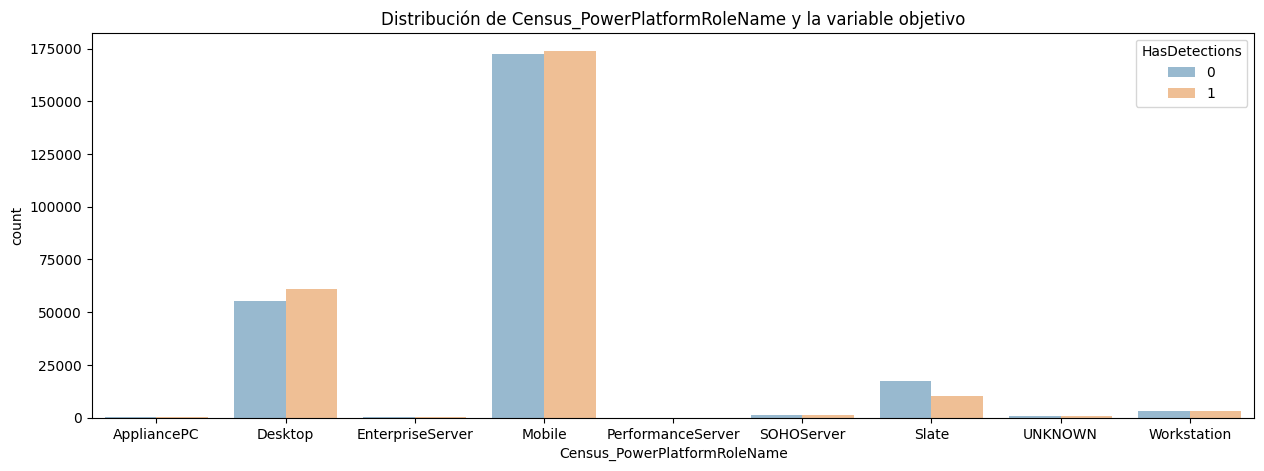

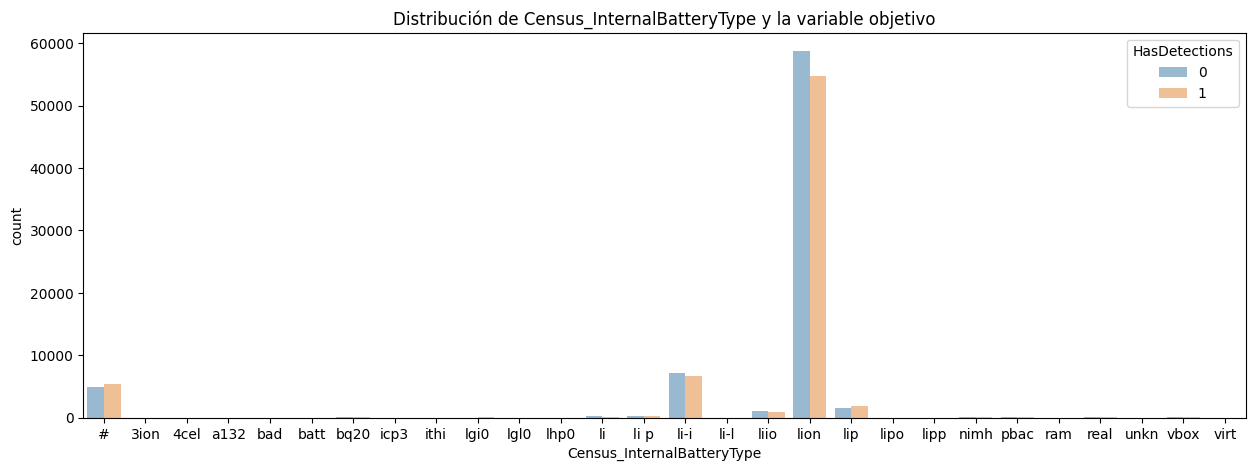

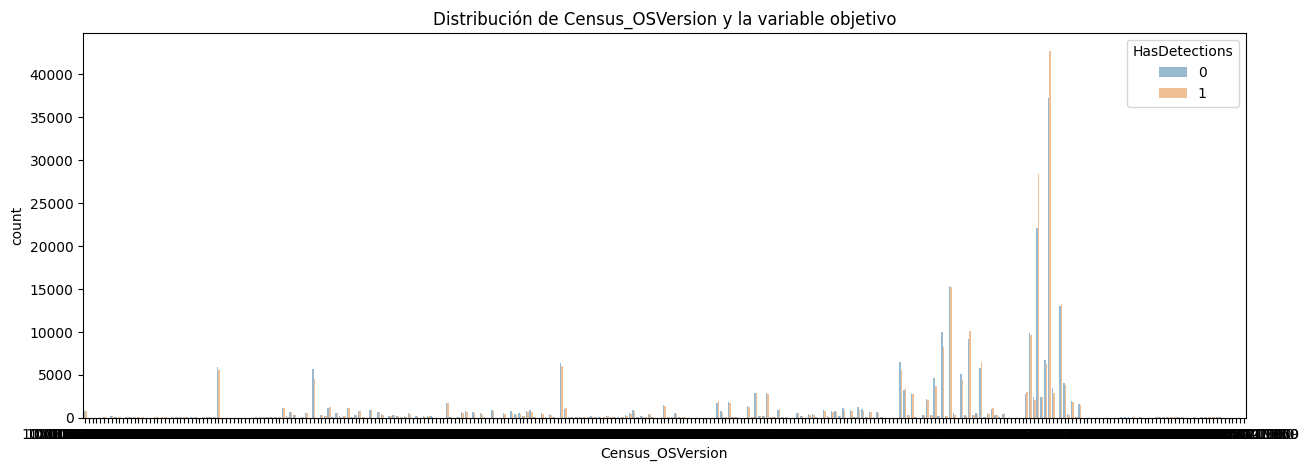

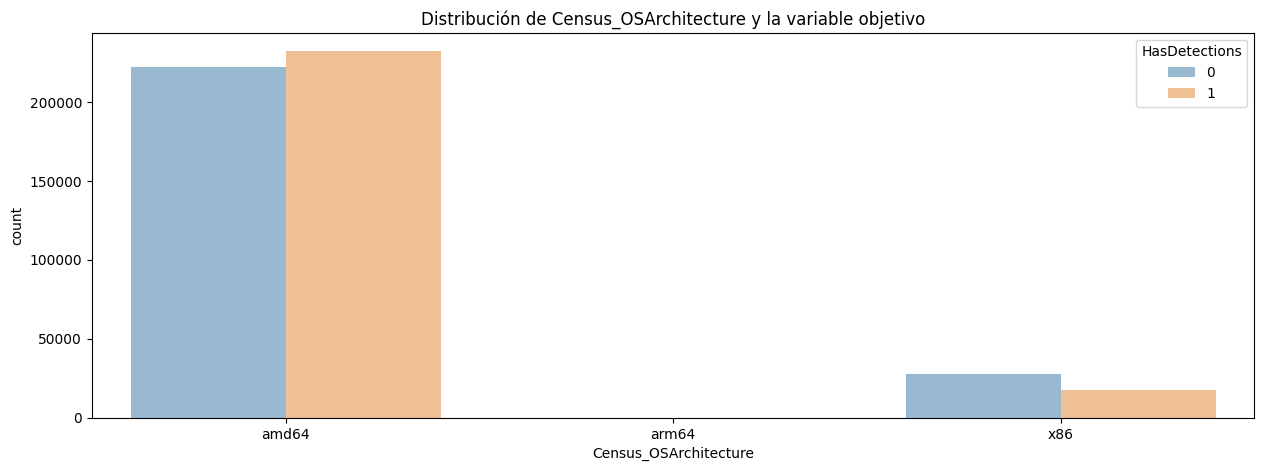

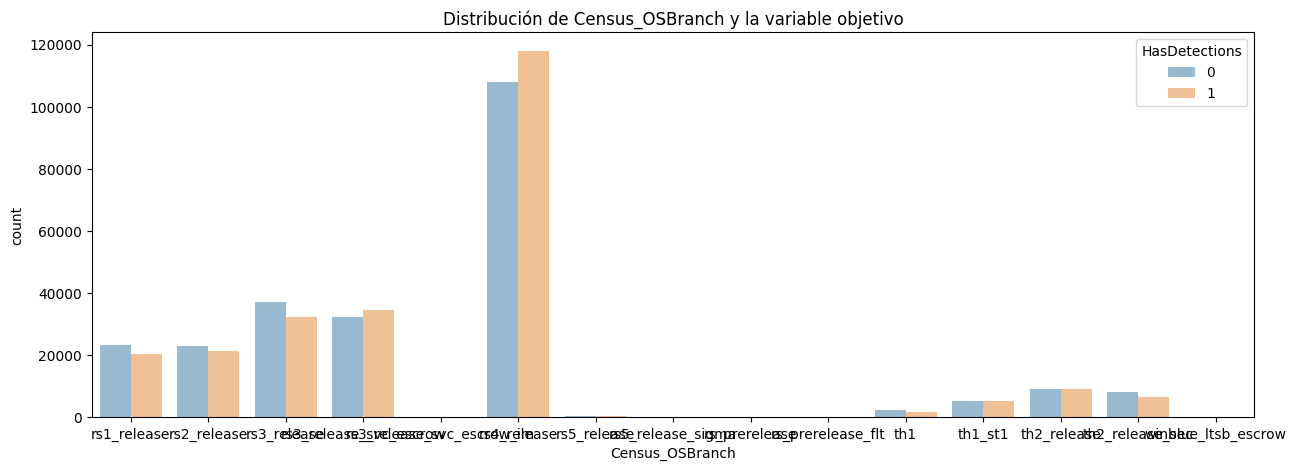

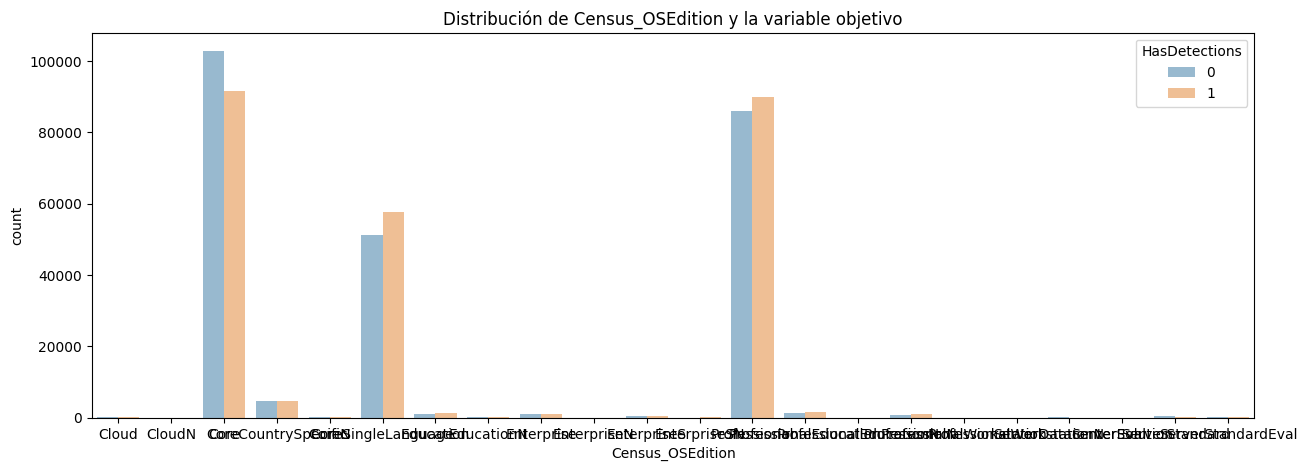

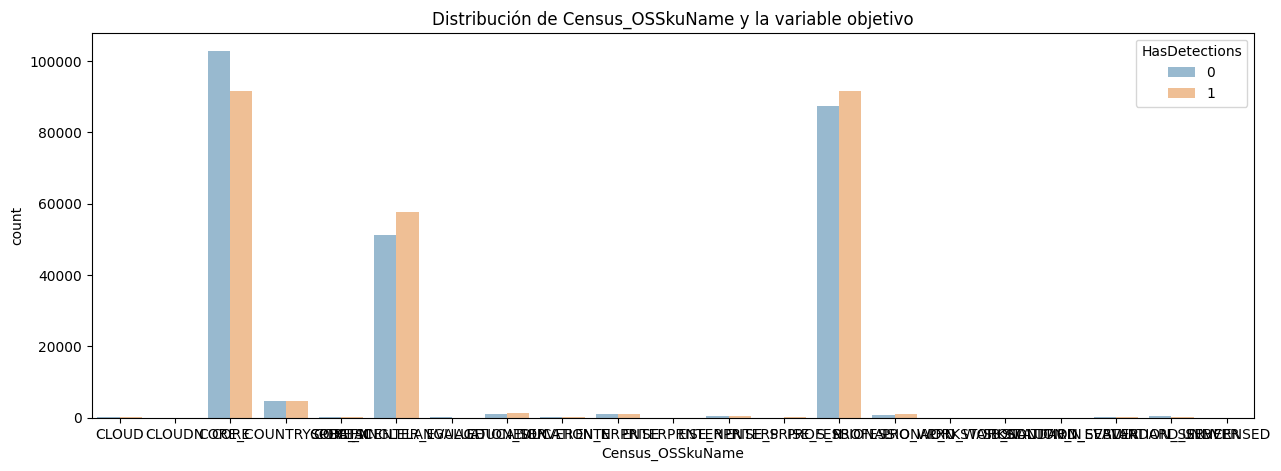

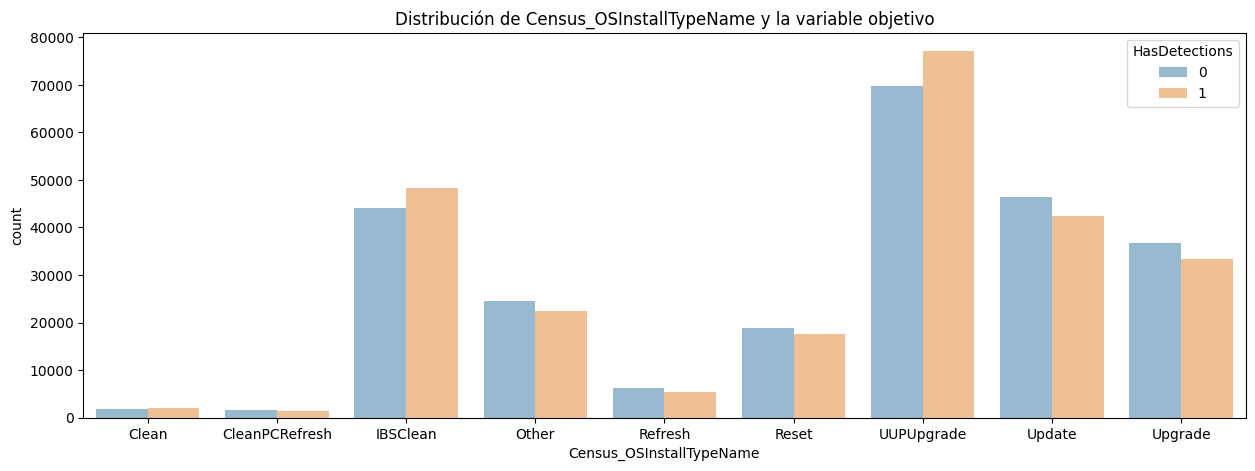

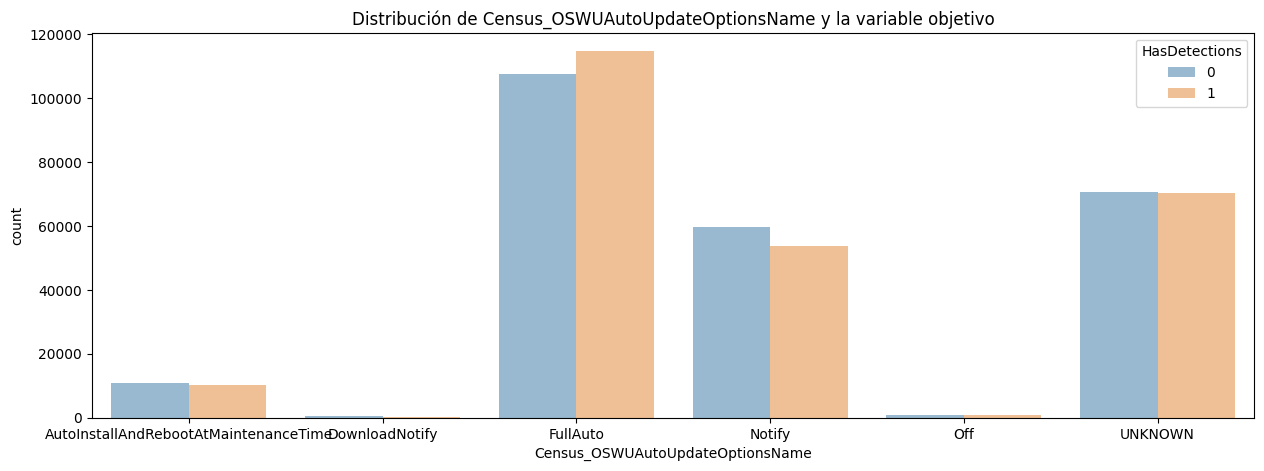

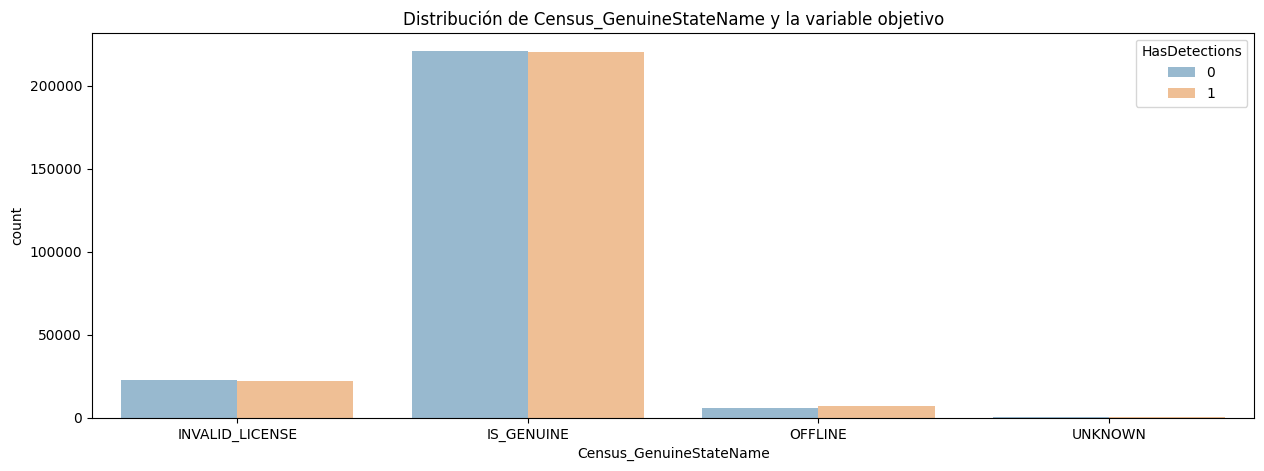

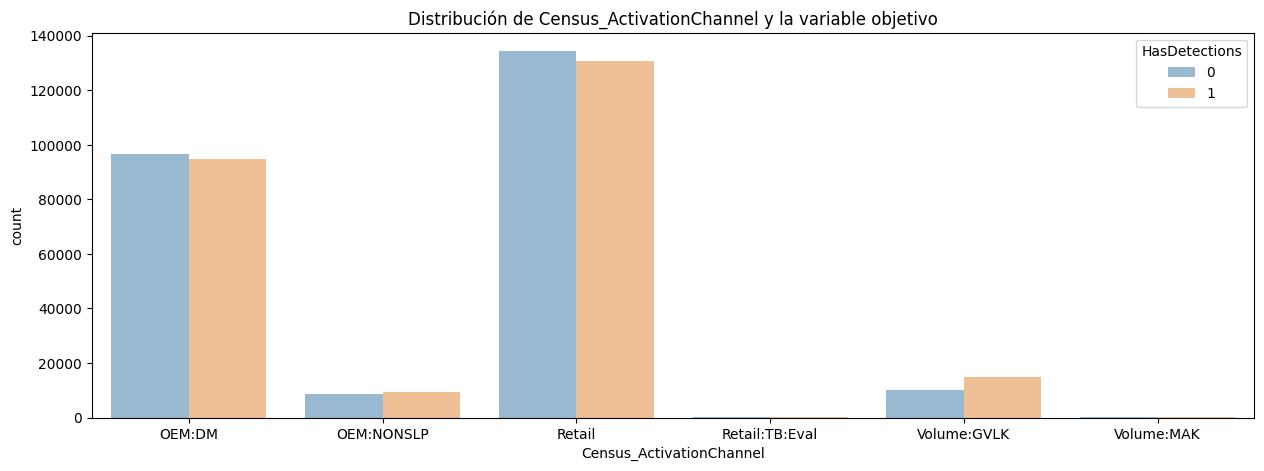

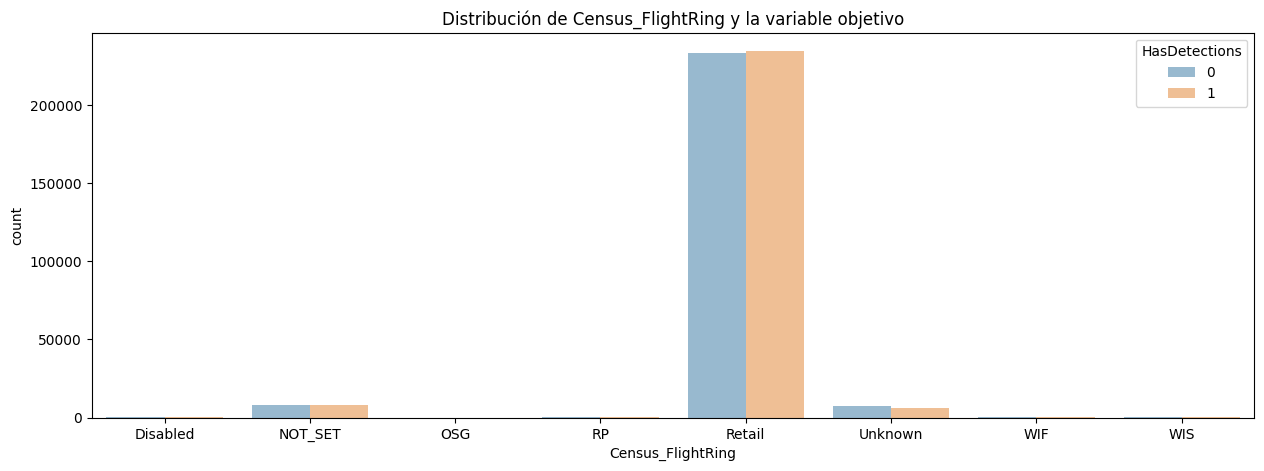

In [38]:
for variable in categoric_cols:
    cat_variable_objetivo(variable)

# Data cleaning

## Duplicates

In [39]:
len(df.drop_duplicates()) / len(df) # Comprobamos si hay filas duplicadas

1.0

In [40]:
len(df.drop_duplicates(subset = ['MachineIdentifier'])) / len(df)
# En efecto, tampoco hay filas duplicadas respecto del campo MachineIdentifier

1.0

## Nulls

In [41]:
nans = []
perc = []
for cols in df:
    nans.append(df[cols].isnull().sum())
    perc.append(df[cols].isnull().sum()/df.shape[0]*100)

missing_data = pd.DataFrame({"Variables":df.columns,"Nans": nans, "%": perc}).sort_values("Nans", ascending=False)
missing_data[missing_data["Nans"]!=0].reset_index(drop=True)

Variables    Nans        %
0                                             PuaMode  499874  99.9748
1                               Census_ProcessorClass  497918  99.5836
2                           DefaultBrowsersIdentifier  475939  95.1878
3                          Census_IsFlightingInternal  415225  83.0450
4                          Census_InternalBatteryType  355603  71.1206
5                               Census_ThresholdOptIn  318104  63.6208
6                             Census_IsWIMBootEnabled  317666  63.5332
7                                         SmartScreen  178596  35.7192
8                              OrganizationIdentifier  154563  30.9126
9                                               SMode   29848   5.9696
10                                     CityIdentifier   18240   3.6480
11                                       Wdft_IsGamer   16950   3.3900
12                              Wdft_RegionIdentifier   16950   3.3900
13              Census_InternalBatteryNumberOfCharges   15038   3.0076
14              Census_FirmwareManufacturerIdentifier   10349   2.0698
15                   Census_FirmwareVersionIdentifier    9061   1.8122
16                           Census_IsFlightsDisabled    8933   1.7866
17                          Census_OEMModelIdentifier    5764   1.1528
18                           Census_OEMNameIdentifier    5381   1.0762
19                                           Firewall    5162   1.0324
20                            Census_TotalPhysicalRAM    4556   0.9112
21            Census_IsAlwaysOnAlwaysConnectedCapable    4040   0.8080
22                 Census_OSInstallLanguageIdentifier    3332   0.6664
23                                    IeVerIdentifier    3209   0.6418
24                    Census_PrimaryDiskTotalCapacity    2976   0.5952
25                   Census_SystemVolumeTotalCapacity    2976   0.5952
26  Census_InternalPrimaryDiagonalDisplaySizeInInches    2654   0.5308
27  Census_InternalPrimaryDisplayResolutionHorizontal    2650   0.5300
28    Census_InternalPrimaryDisplayResolutionVertical    2650   0.5300
29                    Census_ProcessorModelIdentifier    2349   0.4698
30                          Census_ProcessorCoreCount    2347   0.4694
31             Census_ProcessorManufacturerIdentifier    2347   0.4694
32                                  AVProductsEnabled    1938   0.3876
33                          AVProductStatesIdentifier    1938   0.3876
34                                AVProductsInstalled    1938   0.3876
35                                        IsProtected    1926   0.3852
36                                   RtpStateBitfield    1832   0.3664
37                             Census_IsVirtualDevice     901   0.1802
38                         Census_PrimaryDiskTypeName     709   0.1418
39                                       UacLuaenable     623   0.1246
40                             Census_ChassisTypeName      37   0.0074
41                                  GeoNameIdentifier      16   0.0032
42                       Census_PowerPlatformRoleName       2   0.0004
43                                         OsBuildLab       1   0.0002

### Numerical variables

For numerical variables, replace nulls with an out of range value (-1).

In [42]:
for col in numeric_cols:
    df[col] = df[col].fillna(-1)

### Binary variables

Splitting the binary variables and imputing nulls with the mode (to avoid having to do OHE and keeping 0s and 1s).

In [43]:
binary_cols=['Census_HasOpticalDiskDrive','Census_IsAlwaysOnAlwaysConnectedCapable',
        'Census_IsPenCapable', 'Census_IsPortableOperatingSystem',
        'Census_IsSecureBootEnabled','Census_IsTouchEnabled',
        'Census_IsVirtualDevice','Firewall',
        'HasTpm','IsProtected',
        'IsSxsPassiveMode','SMode','Wdft_IsGamer']

In [44]:
for col in binary_cols:
    # replacing NaN w most frequent value
    df[col] = df[col].fillna(df[col].mode()[0])

In [45]:
nans = []
perc = []
for cols in df:
    nans.append(df[cols].isnull().sum())
    perc.append(df[cols].isnull().sum()/df.shape[0]*100)

missing_data = pd.DataFrame({"Variables":df.columns,"Nans": nans, "%": perc}).sort_values("Nans", ascending=False)
missing_data[missing_data["Nans"]!=0].reset_index(drop=True)

Variables    Nans        %
0                                  PuaMode  499874  99.9748
1                    Census_ProcessorClass  497918  99.5836
2               Census_InternalBatteryType  355603  71.1206
3                              SmartScreen  178596  35.7192
4                   OrganizationIdentifier  154563  30.9126
5                           CityIdentifier   18240   3.6480
6                    Wdft_RegionIdentifier   16950   3.3900
7    Census_InternalBatteryNumberOfCharges   15038   3.0076
8    Census_FirmwareManufacturerIdentifier   10349   2.0698
9         Census_FirmwareVersionIdentifier    9061   1.8122
10               Census_OEMModelIdentifier    5764   1.1528
11                Census_OEMNameIdentifier    5381   1.0762
12      Census_OSInstallLanguageIdentifier    3332   0.6664
13                         IeVerIdentifier    3209   0.6418
14         Census_ProcessorModelIdentifier    2349   0.4698
15  Census_ProcessorManufacturerIdentifier    2347   0.4694
16               AVProductStatesIdentifier    1938   0.3876
17              Census_PrimaryDiskTypeName     709   0.1418
18                  Census_ChassisTypeName      37   0.0074
19                       GeoNameIdentifier      16   0.0032
20            Census_PowerPlatformRoleName       2   0.0004
21                              OsBuildLab       1   0.0002

### Rest of variables

* '...Indentifier...': It doesnt make sense to impute an out of range value for identifiers, so im imputing the mode

In [46]:
identifier_columns_with_nan = df.filter(like='Identifier', axis=1).loc[:, df.filter(like='Identifier', axis=1).isna().any()]

df[identifier_columns_with_nan.columns] = df[identifier_columns_with_nan.columns].fillna(df.mode().iloc[0])

* OsBuildLab: I only have 1 null so im dropping it.

In [47]:
df = df.dropna(subset=['OsBuildLab'])

* Census_PowerPlatformRoleName: few nulls, so dropping them

In [48]:
df = df.dropna(subset=['Census_PowerPlatformRoleName'])

* Census_ChassisTypeName

In [49]:
df.Census_ChassisTypeName.value_counts()

Notebook               294232
Desktop                104978
Laptop                  38261
Portable                20181
AllinOne                11407
MiniTower                4849
Convertible              4685
Other                    4215
UNKNOWN                  3695
Detachable               2930
LowProfileDesktop        2878
HandHeld                 2652
SpaceSaving              1689
Tablet                    730
Tower                     692
Unknown                   575
MainServerChassis         512
MiniPC                    261
LunchBox                  224
RackMountChassis          189
SubNotebook                47
BusExpansionChassis        38
30                         11
StickPC                     7
0                           5
Blade                       3
35                          3
PizzaBox                    3
MultisystemChassis          3
SubChassis                  2
31                          2
ExpansionChassis            1
32                          1
25        

In [50]:
df['Census_ChassisTypeName']=df.Census_ChassisTypeName.fillna('UNKNOWN')

<ipython-input-50-6fee29e0eabc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Census_ChassisTypeName']=df.Census_ChassisTypeName.fillna('UNKNOWN')


In [51]:
# mapping as minorities categories with <50 values
df['Census_ChassisTypeName'] = np.where(df['Census_ChassisTypeName'].map(df['Census_ChassisTypeName'].value_counts()) < 50, 'Minorities', df['Census_ChassisTypeName'])

<ipython-input-51-a61189ee7038>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Census_ChassisTypeName'] = np.where(df['Census_ChassisTypeName'].map(df['Census_ChassisTypeName'].value_counts()) < 50, 'Minorities', df['Census_ChassisTypeName'])


* Census_PrimaryDiskTypeName

In [52]:
df.Census_PrimaryDiskTypeName.value_counts()

HDD            325429
SSD            138155
UNKNOWN         20082
Unspecified     15624
Name: Census_PrimaryDiskTypeName, dtype: int64

In [53]:
df['Census_PrimaryDiskTypeName']=df.Census_PrimaryDiskTypeName.fillna('UNKNOWN')

#unknown & unspecified should be one

df['Census_PrimaryDiskTypeName']=np.where(df.Census_PrimaryDiskTypeName=='Unspecified','UNKNOWN',df.Census_PrimaryDiskTypeName)

<ipython-input-53-db01e0b39d05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Census_PrimaryDiskTypeName']=df.Census_PrimaryDiskTypeName.fillna('UNKNOWN')
<ipython-input-53-db01e0b39d05>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Census_PrimaryDiskTypeName']=np.where(df.Census_PrimaryDiskTypeName=='Unspecified','UNKNOWN',df.Census_PrimaryDiskTypeName)


* SmartScreen

In [54]:
df.SmartScreen.value_counts()

RequireAdmin    241592
ExistsNotSet     58496
Off              10388
Warn              7530
Prompt            1950
Block             1274
off                 75
On                  53
&#x02;              20
&#x01;              14
on                   8
requireadmin         1
Name: SmartScreen, dtype: int64

Seeing that on and off are written in different ways, so unifying words + filling out nulls w a new category ('unknown').

In [55]:
df['SmartScreen'] = df['SmartScreen'].str.lower()

# defining a dictionary for mapping values i want to change
mapping = {
    'requireadmin': 'RequireAdmin',
    'existsnotset': 'ExistsNotSet',
    'off': 'Off',
    'on': 'On',
    '&#x02;': '&#x02;',
    '&#x01;': '&#x01;'
}

# mapping 'SmartScreen'
df['SmartScreen'] = df['SmartScreen'].map(mapping)

print(df['SmartScreen'].value_counts())

RequireAdmin    241593
ExistsNotSet     58496
Off              10463
On                  61
&#x02;              20
&#x01;              14
Name: SmartScreen, dtype: int64


In [59]:
df['SmartScreen']=df.SmartScreen.fillna('UNKNOWN')

* Census_InternalBatteryNumberOfCharges

In [ ]:
df.Census_InternalBatteryNumberOfCharges.value_counts()

In [ ]:
#imputing mode since its the # of charges:
df['Census_InternalBatteryNumberOfCharges'] = df['Census_InternalBatteryNumberOfCharges'].fillna(df['Census_InternalBatteryNumberOfCharges'].mode().iloc[0])

In [ ]:
df.isna().any().sum() #verifying i dont have any nulls left

# OHE

Before applying OHE to all categorical variables, im modifying some so i dont have +10 categories for each variable.

In [ ]:
conteo_valores = df[categoric_cols].nunique()

In [ ]:
var_mas10_categorias = conteo_valores[conteo_valores > 10].index.tolist()

Creating a function to group less frequent categories (less than a specific number depending on the variable) in a new category called 'Others'.

In [ ]:
def codificacion_inicial(variable,numero):
    conteo=df[variable].value_counts()
    otros=conteo[conteo<numero].index.tolist()
    df[variable]=df[variable].apply(lambda x: 'Others'if x in otros else x)

to predict  `numero` variable when using the function `codificacion_inicial`, I have inspected each variables using `value_counts`he hecho una inspección con (not showing it in this notebook to ensure simplicity)

In [ ]:
codificacion_inicial('EngineVersion',700)
codificacion_inicial('AppVersion',10000)
codificacion_inicial('AvSigVersion',2000)
codificacion_inicial('OsVer',10000)
codificacion_inicial('OsBuildLab',20000)
codificacion_inicial('Census_MDC2FormFactor',5000)
codificacion_inicial('Census_ChassisTypeName',1000)
codificacion_inicial('Census_OSVersion',10000)
codificacion_inicial('Census_OSBranch',10000)
codificacion_inicial('Census_OSEdition',5000)

I'm going to analyze how many values are for each id, and if theres many (>50), I'll drop it.

In [ ]:
unique_counts = df[id_cols].nunique()
print(unique_counts)

MachineIdentifier                         499997
AVProductStatesIdentifier                   5516
CityIdentifier                             37156
OrganizationIdentifier                        44
GeoNameIdentifier                            268
LocaleEnglishNameIdentifier                  215
IeVerIdentifier                              179
Census_OEMNameIdentifier                    1279
Census_OEMModelIdentifier                  40697
Census_ProcessorManufacturerIdentifier         4
Census_ProcessorModelIdentifier             1767
Census_InternalBatteryNumberOfCharges       5247
Census_OSInstallLanguageIdentifier            39
Census_OSUILocaleIdentifier                   92
Census_FirmwareManufacturerIdentifier        303
Census_FirmwareVersionIdentifier           23569
Wdft_RegionIdentifier                         15
dtype: int64


In [ ]:
var_mas50_categorias = unique_counts[unique_counts > 50].index.tolist()
var_menos50_categorias = unique_counts[unique_counts < 50].index.tolist()
df.drop(columns=var_mas50_categorias, inplace=True)

In [ ]:
var_menos50_categorias

['OrganizationIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_OSInstallLanguageIdentifier',
 'Wdft_RegionIdentifier']

In [ ]:
codificacion_inicial('OrganizationIdentifier',600)
codificacion_inicial('Census_OSInstallLanguageIdentifier',10000)
codificacion_inicial('Wdft_RegionIdentifier',10000)

In [ ]:
#creating a copy for future use
df_2 = df.copy()

Combining both lists of variables I want to transform with get_dunmmies to use it as a function argument.

In [ ]:
col_dummies=categoric_cols+var_menos50_categorias

In [ ]:
df_2 = pd.get_dummies(df_2, columns=col_dummies)

In [ ]:
feature_names_after_ohe = df_2.columns.tolist()

In [ ]:
df_2.shape

(499997, 263)

# I. Training the 1st model

I'm going to train a model to have a reference when performing `RandomizedSearch` + `k-fold validation`

## Train-test split

In [ ]:
X = df_2.drop(columns = target_col) # Matriz de inputs
y = df_2[target_col]

# splitting in train/test w/ a 33%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 2112)

print("Número de observaciones")
print("- Train: ", X_train.shape[0])
print("- Test:  ", X_test.shape[0])

Número de observaciones
- Train:  334997
- Test:   165000


## Training

In [ ]:
from sklearn.tree import DecisionTreeClassifier
#instantiating the model
clf = DecisionTreeClassifier(max_depth = 10)

In [ ]:
# fitting the model
clf.fit(X_train, y_train)
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred).round(2)

0.62

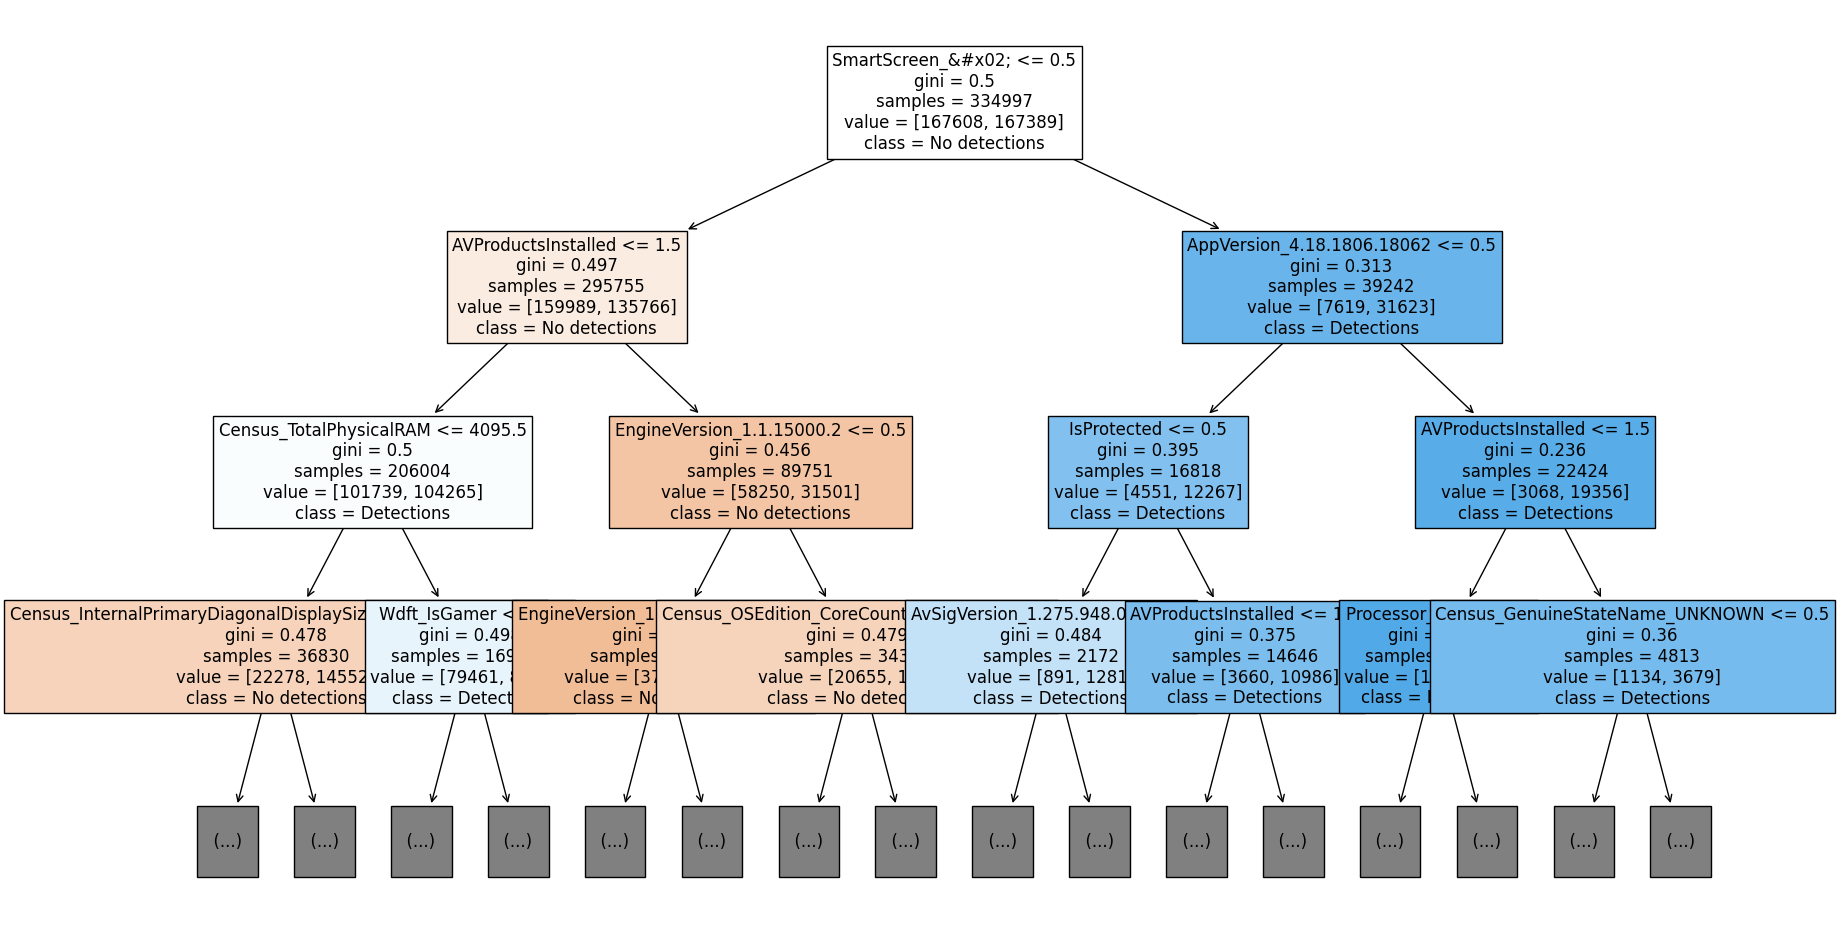

In [ ]:
from sklearn.tree import plot_tree
# Visualización del árbol de decisión
fig = plt.figure(figsize=(20, 12))
plot_tree(
    clf,
    max_depth = 3,
    filled = True,
    class_names = ["No detections", "Detections"],
    feature_names = feature_names_after_ohe,
    fontsize = 12
)
plt.show()

# Selecting the best model

## Decision tree

In [ ]:
decision_tree_params = {
    'criterion': ["gini", "entropy"],
    'max_depth': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

decision_tree = DecisionTreeClassifier()
clf_random_search_decision_tree = RandomizedSearchCV(
    estimator=decision_tree,
    param_distributions=decision_tree_params,
    n_iter=5,
    cv=5,
    scoring="roc_auc",
    return_train_score=True,
    refit=True,
    n_jobs=-1,
    verbose=3,
    random_state=2112
)
clf_random_search_decision_tree.fit(X_train, y_train)

# Random Search results for the Decision Tree
df_output_decision_tree = pd.DataFrame(clf_random_search_decision_tree.cv_results_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


## Random forest

In [ ]:
random_forest_params = {
    'criterion': ["gini", "entropy"],
    'max_depth': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'n_estimators': randint(10, 50)
}

random_forest = RandomForestClassifier(n_jobs=-1)
clf_random_search_random_forest = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=random_forest_params,
    n_iter=5,
    cv=5,
    scoring="roc_auc",
    return_train_score=True,
    refit=True,
    n_jobs=-1,
    verbose=3,
    random_state=2112
)
clf_random_search_random_forest.fit(X_train, y_train)

# Random Search results for Random Forest
df_output_random_forest = pd.DataFrame(clf_random_search_random_forest.cv_results_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


## Gradient boosting

In [ ]:
gradient_boosting_params = {
    'max_depth': randint(2, 5),
    'min_samples_leaf': randint(1, 5),
    'learning_rate': [0.2, 0.1, 0.01],
    'n_estimators': randint(10, 50)
}

gradient_boosting = GradientBoostingClassifier()
clf_random_search_gradient_boosting = RandomizedSearchCV(
    estimator=gradient_boosting,
    param_distributions=gradient_boosting_params,
    n_iter=5,
    cv=5,
    scoring="roc_auc",
    return_train_score=True,
    refit=True,
    n_jobs=-1,
    verbose=3,
    random_state=2112
)
clf_random_search_gradient_boosting.fit(X_train, y_train)

# Random Search results for Gradient Boosting
df_output_gradient_boosting = pd.DataFrame(clf_random_search_gradient_boosting.cv_results_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


## XGBoost

In [ ]:
xgboost_params = {
    'max_depth': randint(2, 5),
    'n_estimators': randint(10, 100),
    'learning_rate': [0.2, 0.1, 0.01],
    'subsample': uniform(0.8, 0.2)
}

xgboost = XGBClassifier(objective='binary:logistic', n_jobs=-1)
clf_random_search_xgboost = RandomizedSearchCV(
    estimator=xgboost,
    param_distributions=xgboost_params,
    n_iter=5,
    cv=5,
    scoring="roc_auc",
    return_train_score=True,
    refit=True,
    n_jobs=-1,
    verbose=3,
    random_state=2112
)
clf_random_search_xgboost.fit(X_train, y_train)

# Random Search results for XGBoost
df_output_xgboost = pd.DataFrame(clf_random_search_xgboost.cv_results_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
df_output_decision_tree['clf'] = 'DecisionTree'
best_estimator_decision_tree = clf_random_search_decision_tree.best_estimator_

df_output_random_forest['clf'] = 'RandomForest'
best_estimator_random_forest = clf_random_search_random_forest.best_estimator_

df_output_gradient_boosting['clf'] = 'GradientBoosting'
best_estimator_gradient_boosting = clf_random_search_gradient_boosting.best_estimator_

df_output_xgboost['clf'] = 'XGBoost'
best_estimator_xgboost = clf_random_search_xgboost.best_estimator_


In [ ]:
# Obtengo el mejor estimador para cada modelo
best_estimators = {
    'DecisionTree': best_estimator_decision_tree,
    'RandomForest': best_estimator_random_forest,
    'GradientBoosting': best_estimator_gradient_boosting,
    'XGBoost': best_estimator_xgboost
}

In [ ]:
best_estimators

{'DecisionTree': DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2),
 'RandomForest': RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_leaf=4,
                        n_estimators=24, n_jobs=-1),
 'GradientBoosting': GradientBoostingClassifier(learning_rate=0.2, max_depth=4, min_samples_leaf=3,
                            n_estimators=24),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=None, missing

In [ ]:
# concatenating all results for each model
df_results = pd.concat([df_output_decision_tree, df_output_random_forest, df_output_gradient_boosting, df_output_xgboost]).reset_index(drop=True)

split_test_score_columns = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
df_results = df_results[
    ['clf', 'rank_test_score', 'mean_train_score', 'mean_test_score', 'std_test_score', 'params']
    + split_test_score_columns
]

In [ ]:
# keeping the best model of each kind
df_best = (
    df_results
    .query('rank_test_score == 1')
    .drop_duplicates(['clf', 'rank_test_score'])
    .sort_values('mean_test_score', ascending=False)
    .reset_index(drop=True)
)

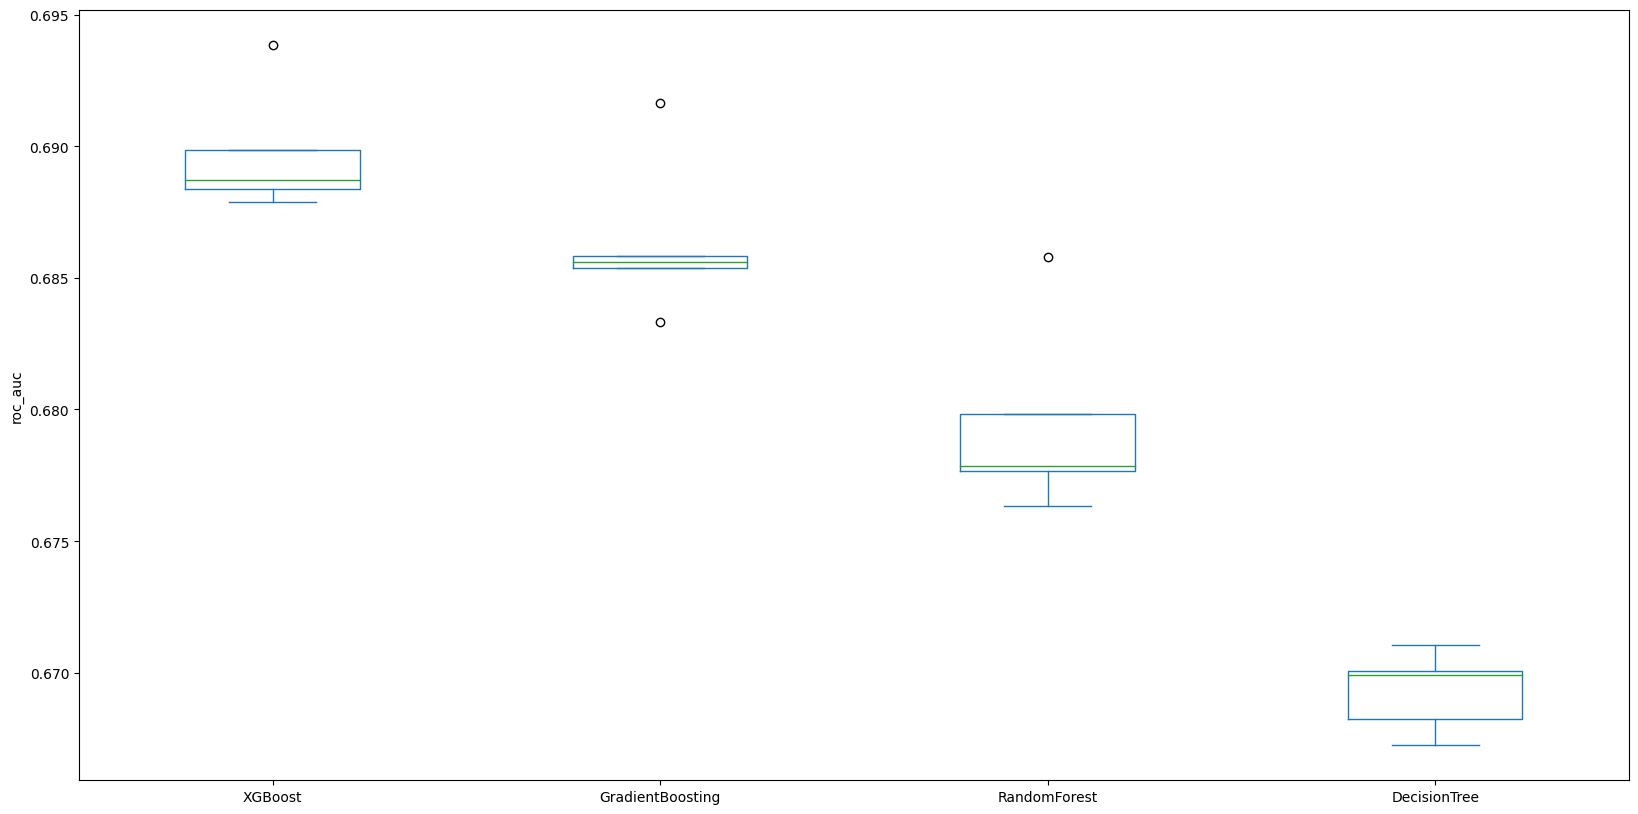

In [ ]:
# Boxplot of test scores of the best model of each kind
df_best.index = df_best['clf']
df_best[split_test_score_columns].T.plot(kind='box', figsize=(20, 10))
plt.ylabel("roc_auc")
plt.show()

In [ ]:
for i, r in df_best.iterrows():
    print(r.clf, "=>", np.round(r.mean_test_score, 4), "\u00B1", np.round(r.std_test_score, 4))

XGBoost => 0.6897 ± 0.0022
GradientBoosting => 0.6864 ± 0.0028
RandomForest => 0.6795 ± 0.0033
DecisionTree => 0.6693 ± 0.0014


In [ ]:
# keeping the best model of all
best_model = best_estimators['XGBoost']
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=67, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# getting performance (ROC AUC) of test set
y_pred = best_model.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_pred)

0.6912888052185779

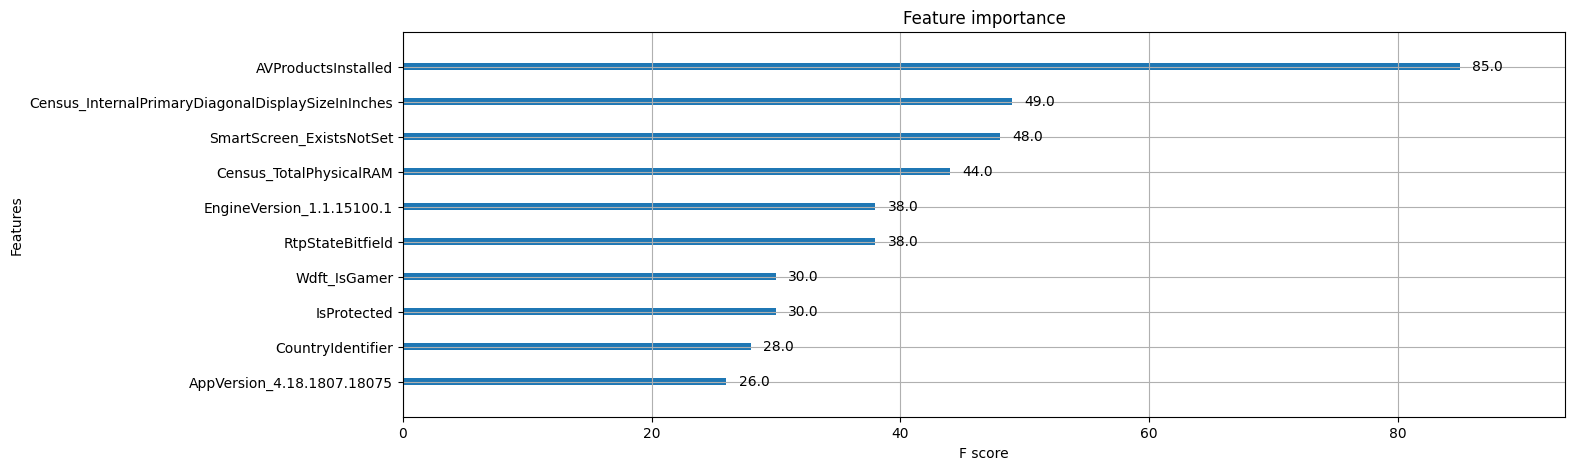

In [ ]:
from xgboost import XGBClassifier, plot_importance
# Visualizing feature importance
plot_importance(best_model, max_num_features=10)
plt.show()

# Conclusions
We observe that the variables with the most importance in my model are as follows:

- AVProductsInstalled: Number of installed antivirus products. A lower value could indicate fewer installed antivirus products, which might increase the risk of infection.

- Census_InternalPrimaryDiagonalDisplaySizeInInches: Diagonal size of the main internal display in inches.

- Smart Screen: If Smart Screen takes the value "Exists Not Set," it could indicate that the Smart Screen setting is not properly configured, potentially affecting the system's ability to detect and block malware.

- Census_TotalPhysicalRAM: Total RAM memory. A lower value could indicate that the system has fewer available memory resources, which might impact its ability to run security software and defend against malware.

- EngineVersion (specifically version 1.1.15100.1): Security engine version. The specific version of the security engine may have particular features relevant to the detection of certain types of malware.

- RtpStateBitfield: Number of bits used to represent the state of the real-time protection feature. This could be an indicator of the effectiveness of real-time protection. A lower value might suggest a less effective state of real-time protection.

- Wdft_IsGamer: Indicates whether the user is a gamer. Gamers often exhibit different behavior patterns compared to non-gamers. They may download and run additional software, participate in online gaming forums, and have specific interactions with technology that differ from those of non-gamers, thereby increasing their exposure to malware threats.

- IsProtected: If the device does not have antivirus protection enabled, it could be more exposed to malware threats.

- CountryIdentifier: Country identifier. Localization can have an impact, as each country has specific regulations and standards, as well as a unique internet infrastructure (directly related to malware detection speed and capability).

- AppVersion (specifically version 4.18.1807.18075): Version of the security product application.